In [62]:
from konlpy.tag import Okt
from konlpy.tag import Kkma
from kiwipiepy import Kiwi
import pandas as pd
import numpy as np
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image 
import re
from collections import Counter
from emoji import core
import ast
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model

In [557]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def _clean_label(x):
    s = str(x)
    # frozenset({'단어'}) -> 단어
    m = re.search(r"\{'(.+?)'\}", s)
    return m.group(1) if m else s

def pretty_heatmap(pivot_data, title="", min_show=0.01, max_items=None, diverging=True):
    df = pivot_data.copy()

    # 1) 라벨 깔끔하게
    df.index = [_clean_label(i) for i in df.index]
    df.columns = [_clean_label(c) for c in df.columns]

    # 2) (선택) 영향 큰 항목만 상위 N개로 줄이기
    if max_items is not None:
        row_score = df.abs().sum(axis=1).sort_values(ascending=False)
        keep = row_score.head(max_items).index
        df = df.loc[keep, keep] if set(keep).issubset(df.columns) else df.loc[keep]

    data = df.to_numpy(dtype=float)

    # 3) 0에 가까운 값은 안 보이게(희소한 히트맵일수록 예쁨)
    mask = np.abs(data) < min_show
    masked = np.ma.array(data, mask=mask)

    # 4) 그림 크기 자동 조절
    n = df.shape[0]
    fig_w = max(8, min(0.45 * n, 18))
    fig_h = max(6, min(0.45 * n, 18))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    # 5) 컬러맵/정규화 (leverage에 음수도 있으면 diverging 추천)
    if diverging:
        vmin = np.nanmin(data)
        vmax = np.nanmax(data)
        norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        im = ax.imshow(masked, cmap="RdBu_r", norm=norm, interpolation="nearest", aspect="equal")
    else:
        im = ax.imshow(masked, cmap="YlGnBu", interpolation="nearest", aspect="equal")

    # 6) 축/라벨
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(df.columns, rotation=45, ha="right", fontsize=9)
    ax.set_yticklabels(df.index, fontsize=9)

    ax.set_xlabel("Consequents")
    ax.set_ylabel("Antecedents")
    ax.set_title(title, pad=12, fontsize=13, weight="bold")

    # 7) 셀 경계선(화이트 그리드)
    ax.set_xticks(np.arange(-.5, df.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, df.shape[0], 1), minor=True)
    ax.grid(which="minor", color="white", linewidth=0.7)
    ax.tick_params(which="minor", bottom=False, left=False)

    # 8) 숫자 표기 (mask 아닌 것만)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if not mask[i, j]:
                ax.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center", fontsize=8)

    # 9) 컬러바
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Leverage")

    fig.tight_layout()
    plt.show()


In [302]:
df = pd.read_csv(
    "../data/saramin_merge_sections_tokeni_v3.csv"
)

df

keyword                                  title   company location  \
0    AI 에이전트       [AI기반 특허 데이터분석 플랫폼 기업] 프론트엔드 개발자     에이피써치   서울 강남구   
1    AI 에이전트  [자율주행] AI Engineer / 3D Auto-labeling   (주)비저너리   서울 강남구   
2    AI 에이전트    [로봇 솔루션기업] 모바일로봇 교통 관제 시스템 설계 및 개발자  (주)맨토스파워   서울 마포구   
3    AI 에이전트  Microsoft 365 Copilot 및 Agent 개발 컨설턴트   (주)무늬랩스   서울 송파구   
4    AI 에이전트     35. AI Platform Engineer [대기업 게임사]  베스트네트워크㈜   서울 강남구   
..       ...                                    ...       ...      ...   
464  AI 에이전트            정부사업/국책과제 담당 인턴 (정규직 전환 가능)     (주)코딧  서울 영등포구   
465  AI 에이전트                    B2B 서비스 기획 담당자 (PO)     (주)코딧  서울 영등포구   
466  AI 에이전트                          정부사업/국책과제 담당자     (주)코딧  서울 영등포구   
467  AI 에이전트                                마케팅 매니저     (주)코딧  서울 영등포구   
468  AI 에이전트                      QA 인턴 (정규직 전환 가능)     (주)코딧  서울 영등포구   

       career education work_type    deadline  \
0    경력 7~15년       대졸↑       정규직         채용시   
1        경력무관       석사↑       정규직         채용시   
2       경력2년↑       대졸↑       정규직  ~ 02/17(화)   
3       경력2년↑      초대졸↑       정규직  ~ 03/04(수)   
4       경력2년↑       대졸↑       정규직  ~ 02/17(화)   
..        ...       ...       ...         ...   
464      경력무관       대졸↑       인턴직         채용시   
465  경력 3~10년       대졸↑       정규직         채용시   
466   경력 3~8년       대졸↑       정규직         채용시   
467  경력 2~10년       대졸↑       정규직         채용시   
468      경력무관      학력무관       인턴직         채용시   

                                                  link   rec_idx  ...  \
0    https://www.saramin.co.kr/zf_user/jobs/relay/v...  52982351  ...   
1    https://www.saramin.co.kr/zf_user/jobs/relay/v...  52981267  ...   
2    https://www.saramin.co.kr/zf_user/jobs/relay/v...  52980063  ...   
3    https://www.saramin.co.kr/zf_user/jobs/relay/v...  52979929  ...   
4    https://www.saramin.co.kr/zf_user/jobs/relay/v...  52979323  ...   
..                                                 ...       ...  ...   
464  https://www.saramin.co.kr/zf_user/jobs/relay/v...  47944456  ...   
465  https://www.saramin.co.kr/zf_user/jobs/relay/v...  47906939  ...   
466  https://www.saramin.co.kr/zf_user/jobs/relay/v...  47893642  ...   
467  https://www.saramin.co.kr/zf_user/jobs/relay/v...  47849094  ...   
468  https://www.saramin.co.kr/zf_user/jobs/relay/v...  47609360  ...   

                                       preferred_quali  \
0    TypeScript에 대한 경험과 이해가 깊은 분\n대규모 프로젝트나 복잡한 업무를...   
1    코드 리뷰를 통해 더 좋은 구조 논의\n주도적으로 문제를 정의하고 해결하는 분\n시...   
2    로봇, AI 관련 업무 유경험자\nMulti-Agent Path Finding(MA...   
3    Copilot Studio (Builder), Power Automate, Powe...   
4                                                  NaN   
..                                                 ...   
464  PPT 작성이나 한글, 엑셀 등 문서 작성에 자신 있는 분\n새로운 제도나 정책을 ...   
465  SaaS 또는 IT 솔루션 서비스 기획을 3년 이상한 경험이 있으신 분\n디자이너,...   
466  정보통신, AI 등 IT 기술분야에 대한 이해도나 관심이 높으신 분\n정부기관의 R...   
467  B2B 콘텐츠 기획/제작 관련 업무 경험이 있으신 분\nB2B 비즈니스의 특성을 이...   
468  모바일 또는 웹서비스의 사용성 테스트에 흥미가 있으신 분\n반복적인 테스트 활동에서...   

                                        hiring_process  \
0    E-mail : wonmi.ahn@apsearch.co.kr\n===========...   
1    Spatial Data Processing\n합류 과정\n서류 검토\n코딩테스트나 ...   
2    e-mail : tender@mantp.co.kr / tender3599@naver...   
3             서류전형 → 1차면접 (부문 리더) → 2차면접 (대표이사) → 최종합격   
4    제출서류: 사람인 온라인 이력서\n접수방법: 사람인 입사지원\n전형절차: 서류전형 ...   
..                                                 ...   
464  지원자분을 더 잘 이해하기 위해 아래 서류를 제출해 주세요\n서류 전형 → 온라인 ...   
465  포지션에 따라 과제가 주어질 수 있습니다.\n지원자분을 더 잘 이해하기 위해 아래 ...   
466  3년 이상 8년 이하 과제 발굴, 수주, 관리, 정산 등 사업 전 과정에 대한 경험...   
467  포지션에 따라 과제가 주어질 수 있습니다.\n지원자분을 더 잘 이해하기 위해 아래 ...   
468  서류 전형 → 테스트 및 온라인 면접 → 대면 면접 → 최종 합격\nhttps://...   

                                              benefits  \
0                                           고용형태 : 정규직   
1    주 3일 출근 (서울 선릉) + 주 2일 재택\n00~16:00\n장비 및 인프라\...   
2                                                  NaN   
3    M365/Copilot/Agent 

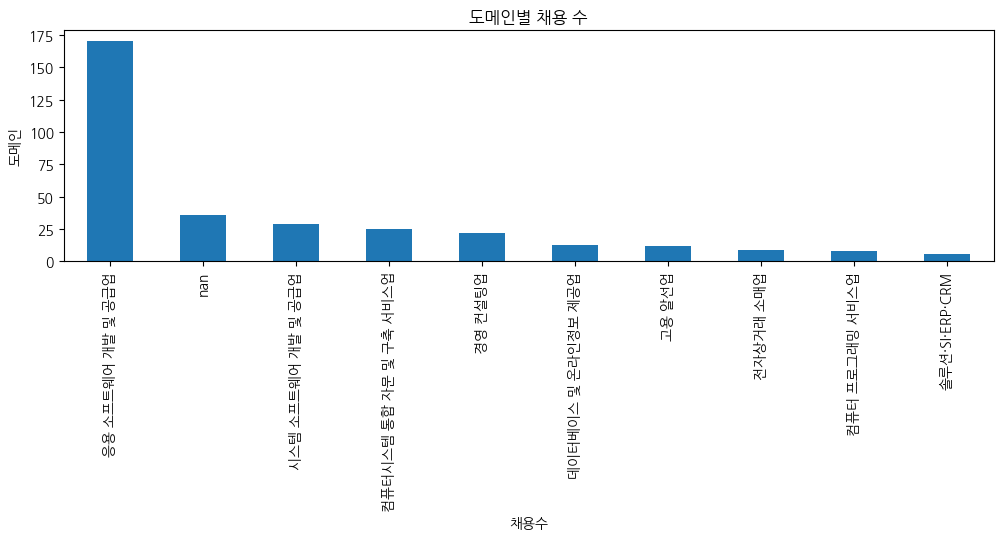

In [552]:

def clean_corp_domain(x):
    s = str(x).strip()
    # 업력/인원 같은 노이즈 제거(필요시 규칙 추가)
    if re.search(r"\d", s) and any(k in s for k in ["년", "명", "업력", "기준"]):
        return None
    return s

df["corp_domain_clean"] = df["corp_domain"].apply(clean_corp_domain)

domain_summary = df["corp_domain_clean"].value_counts().head(10)

plt.figure(figsize=(12,3))
domain_summary.plot(kind="bar")
plt.title("도메인별 채용 수")
plt.ylabel("도메인")
plt.xlabel("채용수")
plt.xticks(rotation=90) # x축 라벨 회전
plt.show()

In [555]:
domain_dict = {
    "금융": ["금융","은행","증권","보험","카드","핀테크","대출","AML"],
    "제조": ["제조","공정","설비","품질","스마트팩토리","생산"],
    "공공": ["공공","정부","기관","지자체","행정"],
    "커머스/유통": ["커머스","이커머스","유통","리테일","쇼핑","주문","결제"],
    "의료/헬스": ["의료","병원","헬스케어","제약","바이오"],
    "물류": ["물류","배송","운송","창고"],
    "교육": ["에듀","강의"],
}

In [556]:
def tag_domains_from_text(text):
    text = "" if pd.isna(text) else str(text)
    tags = []
    for dom, kws in domain_dict.items():
        if any(kw in text for kw in kws):
            tags.append(dom)
    return tags

df["domain_tags"] = df["totaltext"].apply(tag_domains_from_text)

# 도메인별 공고 수 집계
from collections import Counter
c = Counter(tag for tags in df["domain_tags"] for tag in tags)
pd.Series(c).sort_values(ascending=False).head(20)

제조        184
금융        169
공공        126
의료/헬스      84
커머스/유통     63
교육         21
물류         20
dtype: int64

In [305]:
def make_career_group(val):
    t = "" if pd.isna(val) else str(val).strip()
    t = re.sub(r"\s+", " ", t)

    if not t:
        return "미상/기타"

    # 경력무관
    if "무관" in t:
        return "경력무관"

    # 신입 / 신입·경력
    if "신입" in t and "경력" in t:
        return "신입/경력"
    if "신입" in t and "경력" not in t:
        return "신입"

    # 범위: "7~15년"
    m = re.search(r"(\d+)\s*~\s*(\d+)\s*년", t)
    if m:
        mn = int(m.group(1))
        # 그룹은 min 기준(원하면 max 기준/중간값 기준도 가능)
        if mn <= 3:  return "1-3년"
        if mn <= 6:  return "4-6년"
        if mn <= 10: return "7-10년"
        return "11년+"

    # 이상/↑: "경력2년↑", "2년 이상"
    m = re.search(r"(\d+)\s*년\s*(?:↑|이상)", t)
    if m:
        mn = int(m.group(1))
        if mn <= 3:  return "1-3년"
        if mn <= 6:  return "4-6년"
        if mn <= 10: return "7-10년"
        return "11년+"

    # "경력 3년" 같은 형태
    m = re.search(r"경력\s*(\d+)\s*년", t)
    if m:
        mn = int(m.group(1))
        if mn <= 3:  return "1-3년"
        if mn <= 6:  return "4-6년"
        if mn <= 10: return "7-10년"
        return "11년+"

    return "미상/기타"

# ✅ 그룹 컬럼 생성
df["career_group"] = df["career"].apply(make_career_group)

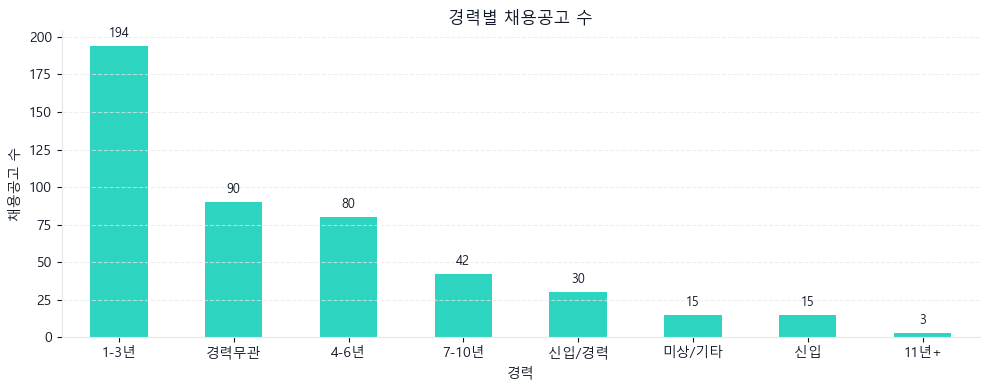

In [590]:
# df["career"].value_counts()
MINT = "#2DD4BF"
GRID = "#E5E7EB"
TEXT = "#111827"

plt.figure(figsize=(10, 4))
ax = career_summary.plot(kind="bar", color=MINT)

plt.title("경력별 채용공고 수", color=TEXT)
plt.xlabel("경력", color=TEXT)
plt.ylabel("채용공고 수", color=TEXT)

plt.grid(axis="y", linestyle="--", alpha=0.7, color=GRID)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color(GRID)
ax.spines["bottom"].set_color(GRID)
ax.tick_params(colors=TEXT)

# 값 라벨(밝은 톤에서 숫자 있으면 더 또렷)
ymax = career_summary.max()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + ymax*0.02,
            f"{int(p.get_height())}", ha="center", va="bottom", color=TEXT, fontsize=9)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [463]:
# 성별 X 연령대 분포에 따른 건당 이용시간
location_summary = df.groupby(["career_group","education"]).value_counts()
location_summary

pivot_table = df.pivot_table(
    index="career_group",
    columns="education",
    aggfunc="size",
    fill_value=0
)

pivot_table

education     고졸↑  대졸  대졸↑  박사  석사↑  초대졸↑  학력무관
career_group                                   
1-3년           12   0   85   1    3    24    69
11년+            0   0    3   0    0     0     0
4-6년            6   1   36   0    1    10    26
7-10년           4   0   20   0    1    13     4
경력무관            2   0   32   4    6     7    39
미상/기타           0   0    6   0    1     1     7
신입              4   0    5   0    0     0     6
신입/경력           3   0   13   0    1     7     6

In [600]:
#주요업무 키워드 분석
career_group = "통합"
result_list = []
remove_list = []
remove_list =[    
    # 채용 절차/지원
    "채용", "모집", "지원", "접수", "서류", "전형", "면접", "과제", "테스트",
    "합격", "불합격", "제출", "안내", "연락", "결과", "일정", "마감",
    "입사", "입사일", "채용절차", "레퍼런스(체크)",

    # 고용/근무조건
    "정규직", "계약직", "인턴", "전환", "수습", "급여", "연봉", "협의",
    "지급", "지급일", "근무시간", "근무지", "출퇴근", "재택", "원격",
    "하이브리드", "야근", "탄력", "휴가", "휴일", "복리후생",

    # 복지/혜택
    "복지", "혜택", "지원금", "식대", "간식", "경조사", "건강검진",
    "보험", "교육비", "도서", "워크샵", "리프레시", "동호회",

    # 회사 소개/홍보 문구
    "글로벌", "성장", "선도", "혁신", "비전", "미션", "최고의", "최상",
    "우수", "함께", "가족", "열정", "도전",

    "전문","지속","도메인","방법","중심","체계","규모","부서","직무","필수","현장","예정","이후","검토","아니","이력서","취소","개월","개인",

    "양재", "서초", "여의도", "과천시", "과천대로", "갈현동"

    # 0) 형태소/어미 찌꺼기(거의 무조건 제거)
    "통하", "대하", "따르", "만들", "원하", "맞추", "빠르", "새롭", "다양", "높이",

    # 1) 문장 연결/범용 표현(정보량 낮음)
    "관련", "사항", "경우", "포함", "대상", "기본", "모든", "전체", "전반", "단계",
    "기존", "일부", "이후", "현재", "사실", "때문", "이런", "아니", "미리", "언제",

    # 2) 범용 업무 동사/명사(단독으론 너무 흔함 → 토픽을 뭉개는 주범)
    "개발", "설계", "구축", "운영", "구현", "기획", "관리", "수행", "담당", "진행",
    "수립", "작성", "제공", "도출", "적용", "연동", "연계", "연결", "통합", "처리",
    "검토", "대응", "발굴", "유지", "구성",

    # 3) 범용 역량/자격 표현(거의 모든 공고에 등장)
    "경험", "역량", "능력", "지식", "이해", "전문", "실무", "자격", "요건", "우대",
    "필요", "가능",

    # 4) 너무 넓은 조직/비즈니스 일반어(인재상 신호를 흐리는 편)
    "업무", "기업", "조직", "회사", "사내", "부서", "직무", "사업", "비즈니스",
    "고객", "고객사", "시장", "제품", "프로젝트", "전략", "로드맵",

    # 5) 추상/홍보성 표현(회사 소개 문구에 가까움)
    "성장", "핵심", "가치", "문화", "혁신", "글로벌", "함께", "우리",

    # 6) 근무/채용/복지 쪽(주요업무 분석이면 보통 제거)
    "채용", "서류", "면접", "전형", "접수", "제출", "합격", "모집", "입사",
    "근무", "정규직", "계약", "계약직", "수습", "연차", "급여", "연봉", "지급", "보수", "수당",
    "휴가", "복지", "혜택", "보험", "간식", "교육", "건강", "검진", "경조사", "포상",
    "출퇴근", "근무지", "사무실", "기간", "개월", "이력서", "자기소개서",

    # 7) 기타 잡음(업무 내용과 무관하게 섞이기 쉬운 것)
    "페이지", "영상", "노트북", "키트",

    "네일", "웨비", "놀랍", "마지막", "아끼", "수백", "코딧", "CODIT", "에이액스",
    "최고", "다수", "법령", "TEAM", "스타트업", "규제", "투자",
    "HTTPS", "파트너스", "코딧", "인베스트", "인베스트먼트", "YOUTU", "프리미어", "의안", "법령",
    "BUILDING", "XBBQOESME", "BE", "엔터프라이즈", "유치", "여정", "SCALE", "UP", "국내외", "통하", "유망"
]
remove_list0 = ['AI','AL','AGENT','에이전트','위하','이상','또는', "에이", "전트"]
remove_list1 = ['운영','설계','개발','기반']
remove_list2 = ['구축', '서비스', '데이터', '업무','기술','시스템']
remove_list3 = ['LLM','분석','관리','경험','개선','지원','환경','활용']
remove_list4 = ['최적','모델','가능','구현','기획']
remove_list5 = ['사항','사용','통하','고객']
remove_list6 = ['제공','함께','다양','협업','자동']
remove_list7 = ['파이프라인','RAG','성능','필요','기능','API']
remove_list8 = ['기업','수행','수립']
remove_list9 = ['최신','고도','플랫폼','작성','관련']
remove_list10 = ['결정','효율','경력','대하']
remove_list11 = ['구조','역량','분야','품질','엔드','요구']
remove_list12 = ['생성','채용','전환','문서','제품','성장']
remove_list13 = ['비즈니스','해결','요건','프로젝트','조직','만들','연동']
remove_list14 = ['이해','자격','신규','사용자','경우']
remove_list15 = ['주도', '문제', '우대', '배포']
remove_list16 = ['핵심','적용','근무','담당','전략']
remove_list17 = ['사업','정의','프로','평가','학습']
remove_list18 = ['소프트웨어','능력','아키텍처','대응','솔루션']
remove_list19 = ['성과','서류','확장','진행','프로세스','최종']
remove_list20 = []
remove_list.extend(remove_list0)
# remove_list.extend(remove_list1)
# remove_list.extend(remove_list2)
# remove_list.extend(remove_list3)
# remove_list.extend(remove_list4)
# remove_list.extend(remove_list5)
# remove_list.extend(remove_list6)
# remove_list.extend(remove_list7)
# remove_list.extend(remove_list8)
# remove_list.extend(remove_list9)
# remove_list.extend(remove_list10)
# remove_list.extend(remove_list11)
# remove_list.extend(remove_list12)
# remove_list.extend(remove_list13)
# remove_list.extend(remove_list14)
# remove_list.extend(remove_list15)
# remove_list.extend(remove_list16)
# remove_list.extend(remove_list17)
# remove_list.extend(remove_list18)
# remove_list.extend(remove_list19)
# remove_list.extend(remove_list20)
# remove_list.remove('서비스')

for respons_text in df.loc[df["career_group"] == career_group , "respons_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)
    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.extend(data_list)

counter = Counter(result_list)

wc = WordCloud(
    font_path = r"c:\Windows\Fonts\malgun.ttf",
    background_color="white",
    width=800,
    height=400
)

# wc.generate_from_frequencies(counter)

# plt.Figure(figsize=(5,5))
# plt.imshow(wc, interpolation="bilinear")
# plt.axis("off")
# plt.title("주요업무", fontsize=15)
# plt.show()

In [134]:
counter

Counter({'기반': 256,
         '서비스': 231,
         '기술': 196,
         '데이터': 196,
         '활용': 180,
         '분석': 176,
         '시스템': 170,
         'LLM': 134,
         '개선': 124,
         '모델': 120,
         '통하': 114,
         '플랫폼': 114,
         '최적': 114,
         '솔루션': 107,
         '자동': 103,
         '파이프라인': 100,
         '성능': 92,
         '문제': 91,
         'RAG': 84,
         '협업': 83,
         '해결': 83,
         'API': 81,
         '환경': 80,
         '고도': 80,
         '기능': 78,
         '엔드': 75,
         '정보': 75,
         '생성': 74,
         '요구': 67,
         '정책': 67,
         '구조': 66,
         '품질': 65,
         '결정': 65,
         '여정': 62,
         '사용': 60,
         '최고': 60,
         '분야': 59,
         '아키텍처': 58,
         '정의': 57,
         '의사': 56,
         '맞춤': 56,
         '자사': 55,
         '개발자': 55,
         '평가': 54,
         '적극': 54,
         '학습': 53,
         '인프라': 53,
         '워크': 53,
         '변화': 53,
         '사용자': 52,
         '규제': 51,

In [601]:
career_group = "1-3년"
#네트워크 분석을 위한 데이터 만들기
te = TransactionEncoder()

result_list = []    #불필요한 단어 제거된 결과


#for respons_text in df["respons_text"]:
for respons_text in df.loc[df["career_group"] == career_group , "respons_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.append(data_list)   

te_arr = te.fit(result_list).transform(result_list)

df_arr = pd.DataFrame(te_arr, columns=te.columns_)

frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
rules_all = association_rules(frequent_itemsets, metric="support", min_threshold=0)
rules_all = rules_all[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage']]
max_sup  = 0.7   # 예:  이상 같이 나오는 규칙
min_sup  = 0.05   # 예: 12% 이상 같이 나오는 규칙
min_conf = 0.50   # 예: A가 나오면 B도 50% 이상
min_lift = 1.20   # 예: 독립(1.0)보다 의미 있게 높게
min_lev = rules_all['leverage'].quantile(0.50)  # 상위 25%만

# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.1)

# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets,metric="lift",min_threshold=1.2)

rulesV2 = rules_all[
    (rules_all['support'] >= min_sup) &
    (rules_all['support'] <= max_sup) &
    (rules_all['confidence'] >= min_conf) &
    (rules_all['lift'] >= min_lift) &
    (rules_all['leverage'] >= min_lev)
].copy()

rulesV2 = rulesV2.sort_values(
    by=['leverage', 'confidence', 'lift', 'support'],
    ascending=False
)


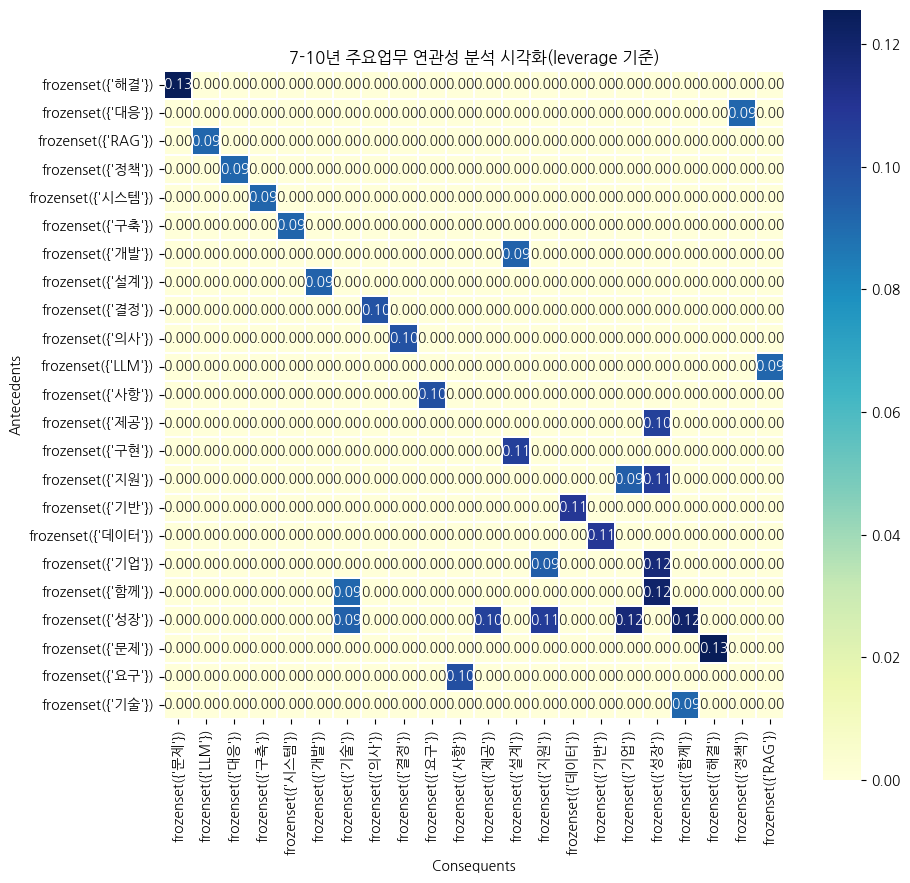

In [567]:
# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.1)

# 히트맵 그리기
pivot_data = rulesV2.head(30).pivot_table(
    index="antecedents",
    columns="consequents",
    values="leverage",
    fill_value=0
)
plt.figure(figsize=(10,10))
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.3, square=True)
plt.title(f"{career_group} 주요업무 연관성 분석 시각화(leverage 기준)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.show()

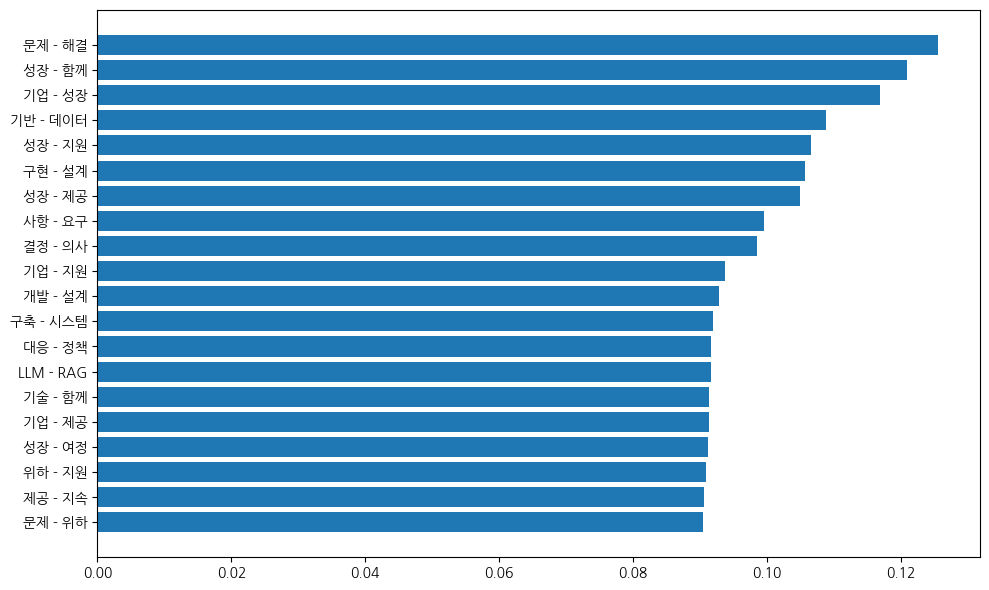

In [573]:
def fs_to_str(x):
    return ",".join(sorted(list(x)))

A = rulesV2["antecedents"].apply(fs_to_str)
B = rulesV2["consequents"].apply(fs_to_str)

#rules_uni = rulesV2[A <= B].copy()
rules_uni["pair"] = A[A <= B] + " - " + B[A <= B]

topN = 20
top = rules_uni.head(topN).iloc[::-1]

plt.figure(figsize=(10, max(6, 0.2*len(top)+1)))
plt.barh(top["pair_ud"] if "pair_ud" in top else top["pair"], top["leverage"])
plt.tight_layout()
plt.show()

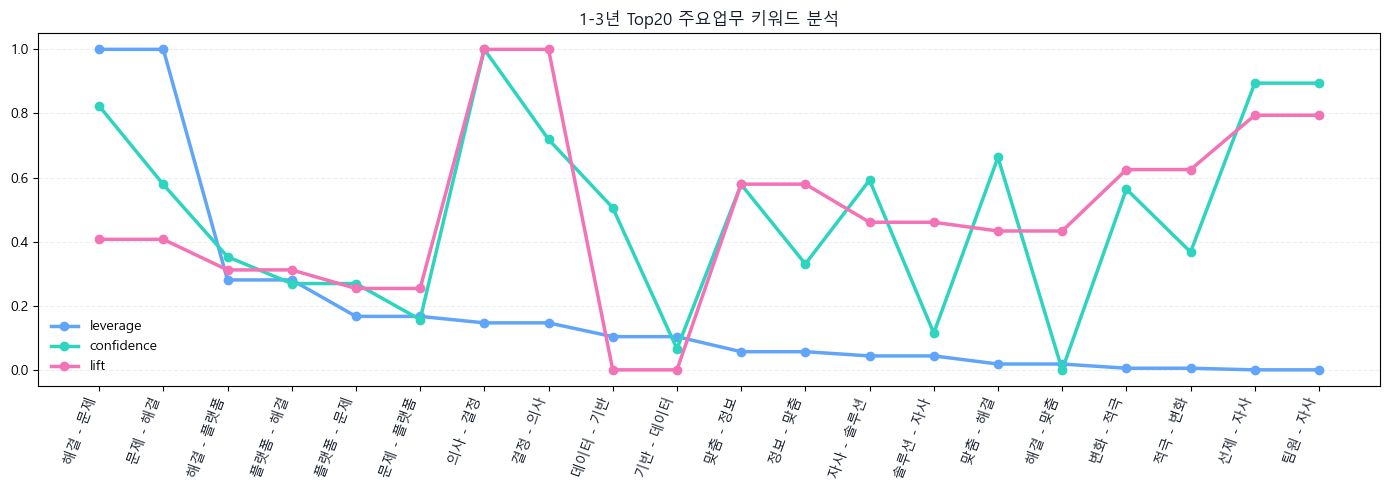

In [602]:
MINT   = "#2DD4BF"
SKY    = "#60A5FA"
PINK   = "#F472B6"
GRID   = "#E5E7EB"
TEXT   = "#111827"

topN = 20
top = rulesV2.head(topN).copy()
A = rulesV2["antecedents"].apply(fs_to_str)
B = rulesV2["consequents"].apply(fs_to_str)
metrics = ["leverage", "confidence", "lift"]
top["pair"] = A + " - " + B

# 보기좋게 정규화(스케일이 달라서 그냥 그리면 leverage가 너무 작게 보일 수 있음)
norm = top[metrics].copy()
norm = (norm - norm.min()) / (norm.max() - norm.min())

x = range(topN)
plt.figure(figsize=(14, 5))

plt.plot(x, norm["leverage"],   marker="o", linewidth=2.5, label="leverage",   color=SKY)
plt.plot(x, norm["confidence"], marker="o", linewidth=2.5, label="confidence", color=MINT)
plt.plot(x, norm["lift"],       marker="o", linewidth=2.5, label="lift",       color=PINK)
plt.xticks(list(x), top["pair"], rotation=70, ha="right", color=TEXT)
plt.title(f"{career_group} Top{len(top)} 주요업무 키워드 분석", color=TEXT)
plt.grid(axis="y", linestyle="--", alpha=0.7, color=GRID)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

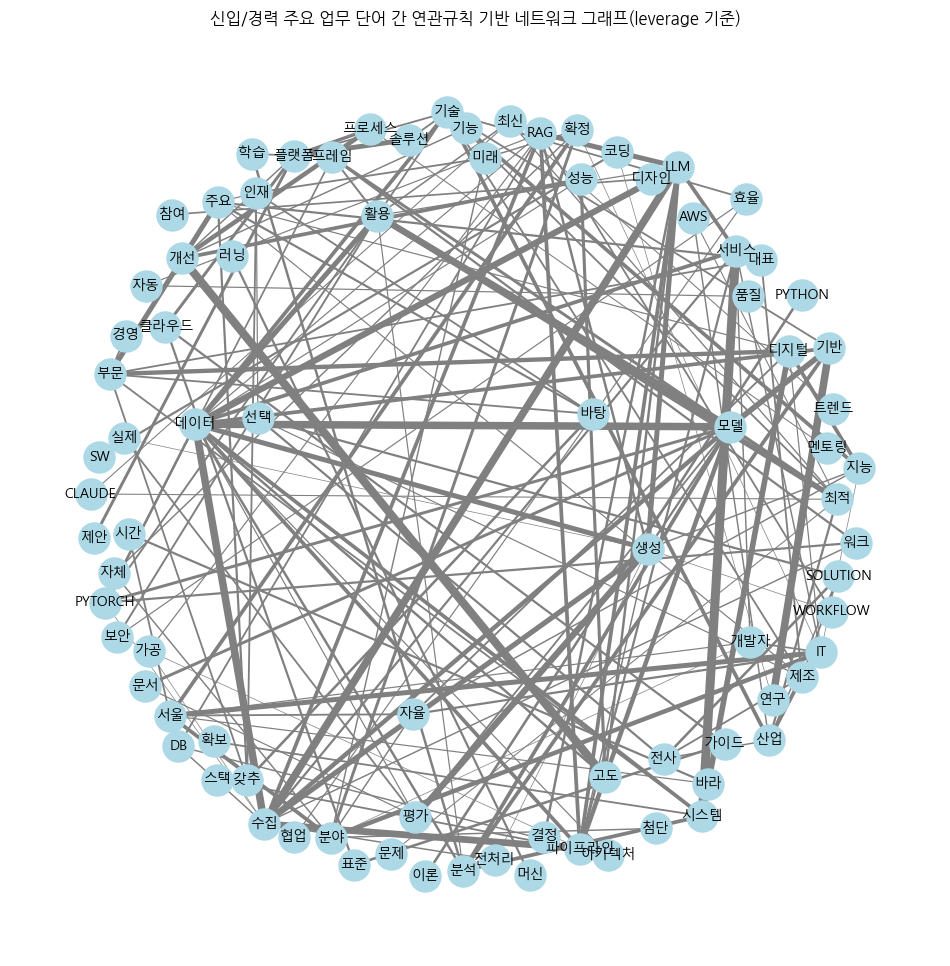

In [448]:
#네트워크 그래프 그리기
# 1. 그래프 생성
G = nx.Graph()

# 2. 엣지 추가
## 보여주고 싶은 데이터 설정하기
my_rules = rulesV2.head(300)

for _ , col_data in my_rules.iterrows():
    # 1) 단어 추출
    antecedent = ",".join(col_data["antecedents"])
    consequent = ",".join(col_data["consequents"])

    # 2) 지표 추출
    weight = col_data["leverage"]

    # 3) 그래프에 정보 추가
    G.add_edge(antecedent, consequent, weight=weight)

# 3. 노드 배치
# position = nx.kamada_kawai_layout(G)
position = nx.spring_layout(G, k=1.0, seed=10)

# 4. 가중치 추출
scale = 1 # 선의 굵기가 너무 굵다면 사이즈를 줄일수 있습니다
edge_weights = [G[u][v]["weight"]*scale for u, v in G.edges()]
w = np.array(edge_weights, dtype=float)
w_norm = (w - w.min()) / (w.max() - w.min() + 1e-9)   # 0~1
w_scaled  = 0.5 + w_norm * 6

# 5. 그리기
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G, position, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G, position, edge_color="gray", width=w_scaled)
nx.draw_networkx_labels(G, position, font_size=10, font_family="Malgun Gothic")
plt.title(f"{career_group} 주요 업무 단어 간 연관규칙 기반 네트워크 그래프(leverage 기준)")
plt.axis("off")
plt.show()

In [402]:
sent_list = []

for result in result_list:
    result_str = " ".join(result)
    sent_list.append(result_str)
        
count_vectorizer = CountVectorizer(
    max_df=0.1,         # 전체 단어의 등장 비율이 p이상인 것만 사용
    min_df=2,           # 이 단어가 적어도 n개 이상 있는 것만 사용
    max_features=1000,  # 최대 몇 개까지 나타낼 것인가
    ngram_range=(1,2)   # 단어의 조합 설정(ex. 1개만 사용)
)
feat_vec = count_vectorizer.fit_transform(sent_list)

df_vec = pd.DataFrame(
    feat_vec.toarray(),
    columns=count_vectorizer.get_feature_names_out()
)

lda = LatentDirichletAllocation(n_components=3)
lda.fit(feat_vec)

pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, feat_vec, count_vectorizer)
pyLDAvis.display(vis)

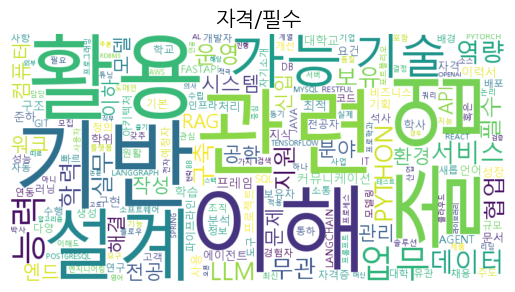

In [509]:
#자격/필수 키워드 분석
remove_list = ['AI',' AL',' AGENT','위하','이상','또는','경력','경험','개발','대하']    #불필요한 단어리스트
result_list = []    #불필요한 단어 제거된 결과

for respons_text in df["qualifi_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.extend(data_list)

counter = Counter(result_list)

wc = WordCloud(
    font_path = r"c:\Windows\Fonts\malgun.ttf",
    background_color="white",
    width=800,
    height=400
)

wc.generate_from_frequencies(counter)

plt.Figure(figsize=(5,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("자격/필수", fontsize=15)
plt.show()

In [500]:
#네트워크 분석을 위한 데이터 만들기
te = TransactionEncoder()

remove_list = ['AI',' AL',' AGENT','위하','이상','또는','경력','경험','개발','대하']    #불필요한 단어리스트
result_list = []    #불필요한 단어 제거된 결과

for respons_text in df["qualifi_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.append(data_list)   

te_arr = te.fit(result_list).transform(result_list)

df_arr = pd.DataFrame(te_arr, columns=te.columns_)

frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
rules_all = association_rules(frequent_itemsets, metric="support", min_threshold=0)
rules_all = rules_all[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage']]
max_sup  = 0.5   # 예:  이상 같이 나오는 규칙
min_sup  = 0.02   # 예: 12% 이상 같이 나오는 규칙
min_conf = 0.50   # 예: A가 나오면 B도 50% 이상
min_lift = 1.20   # 예: 독립(1.0)보다 의미 있게 높게
min_lev = rules_all['leverage'].quantile(0.50)  # 상위 25%만

rulesV2 = rules_all[
    (rules_all['support'] >= min_sup) &
    (rules_all['support'] <= max_sup) &
    (rules_all['confidence'] >= min_conf) &
    (rules_all['lift'] >= min_lift) &
    (rules_all['leverage'] >= min_lev)
].copy()

rulesV2 = rulesV2.sort_values(
    by=['leverage', 'confidence', 'lift', 'support'],
    ascending=False
)

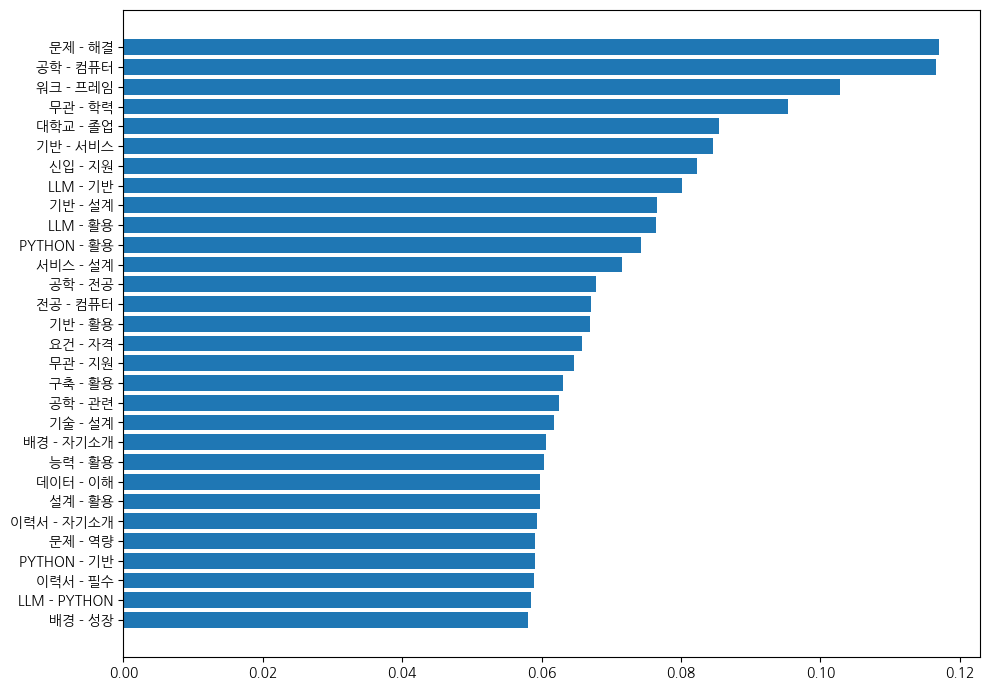

In [507]:
def fs_to_str(x):
    return ",".join(sorted(list(x)))

A = rulesV2["antecedents"].apply(fs_to_str)
B = rulesV2["consequents"].apply(fs_to_str)

rules_uni = rulesV2[A <= B].copy()
rules_uni["pair"] = A[A <= B] + " - " + B[A <= B]

topN = 30
top = rules_uni.head(topN).iloc[::-1]

plt.figure(figsize=(10, max(6, 0.2*len(top)+1)))
plt.barh(top["pair_ud"] if "pair_ud" in top else top["pair"], top["leverage"])
plt.tight_layout()
plt.show()

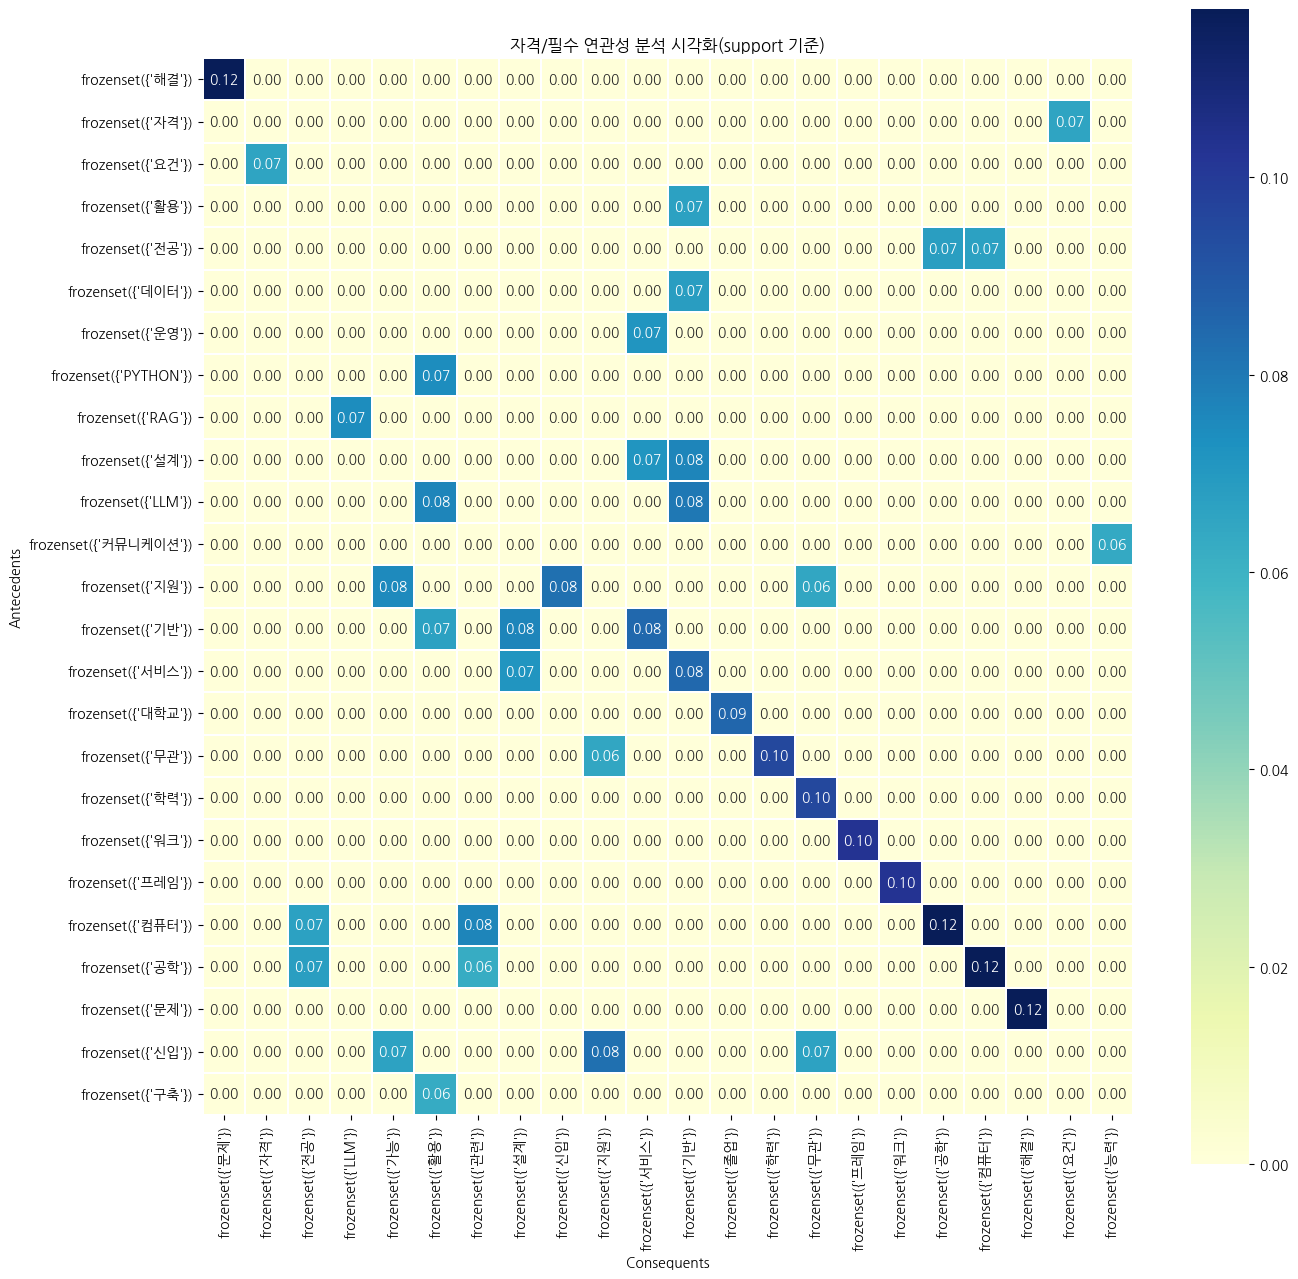

In [503]:
frequent_itemsets = apriori(df_arr, min_support=0.003, use_colnames=True, max_len=2)
rules = association_rules(frequent_itemsets, metric="leverage", min_threshold=0.1)

# 히트맵 그리기
pivot_data = rulesV2.head(40).pivot_table(
    index="antecedents",
    columns="consequents",
    values="leverage",
    fill_value=0
)
plt.figure(figsize=(15,15))
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.3, square=True)
plt.title("자격/필수 연관성 분석 시각화(support 기준)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.show()

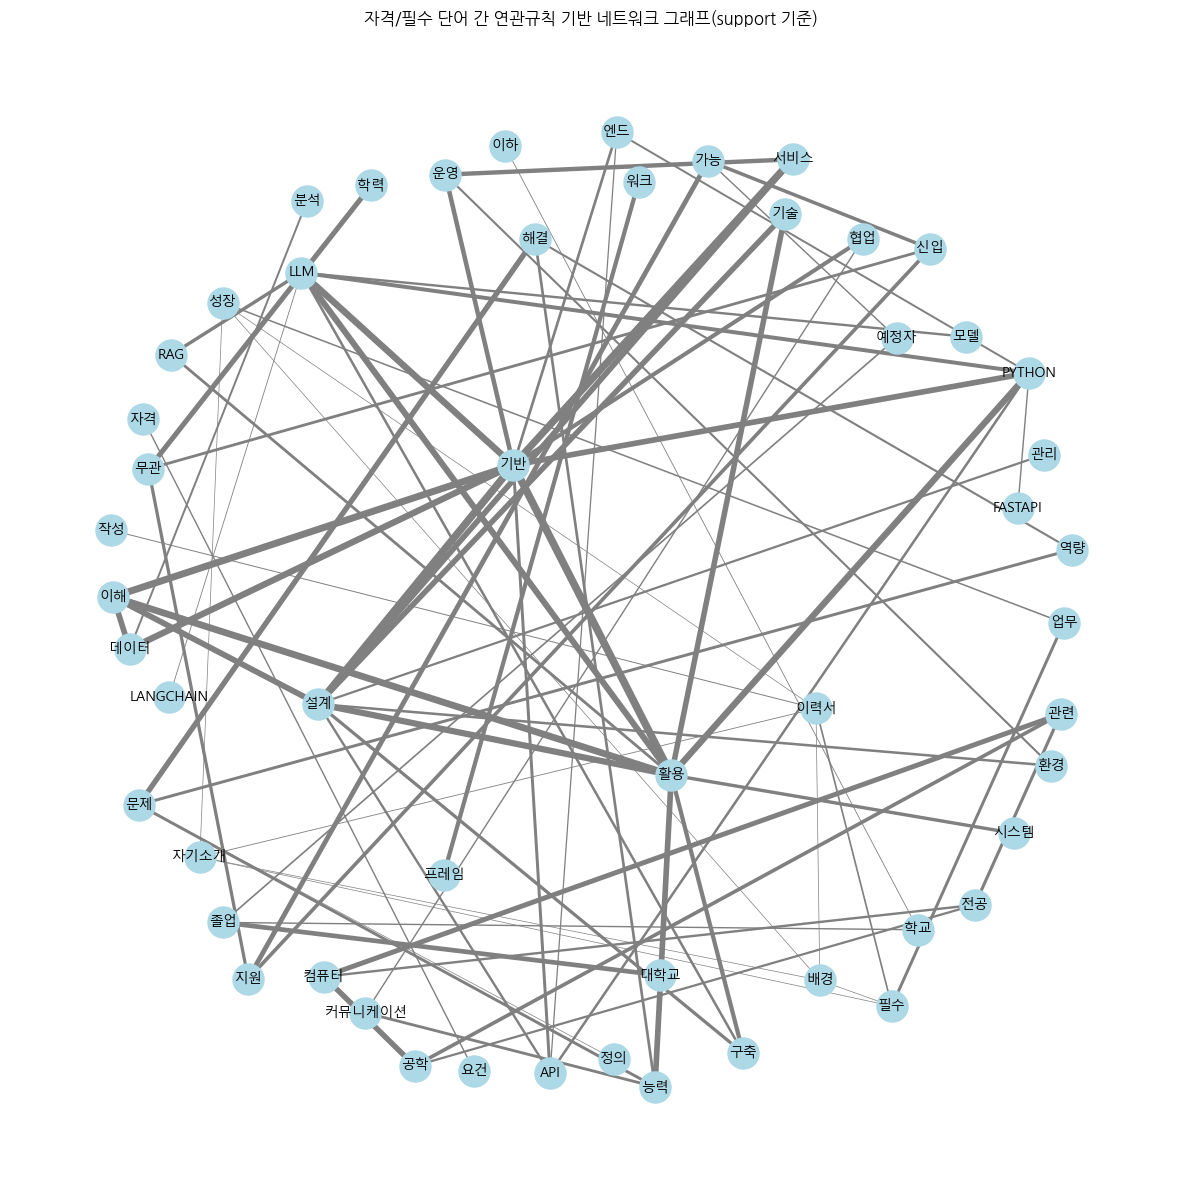

In [508]:

frequent_itemsets = apriori(df_arr, min_support=0.001, use_colnames=True, max_len=2)
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.1)
#네트워크 그래프 그리기
# 1. 그래프 생성
G = nx.Graph()

# 2. 엣지 추가
## 보여주고 싶은 데이터 설정하기
my_rules = rulesV2.head(100)

for _ , col_data in my_rules.iterrows():
    # 1) 단어 추출
    antecedent = ",".join(col_data["antecedents"])
    consequent = ",".join(col_data["consequents"])

    # 2) 지표 추출
    weight = col_data["support"]

    # 3) 그래프에 정보 추가
    G.add_edge(antecedent, consequent, weight=weight)

# 3. 노드 배치
# position = nx.kamada_kawai_layout(G)
position = nx.spring_layout(G, k=1.0, seed=1)

# 4. 가중치 추출
scale = 1 # 선의 굵기가 너무 굵다면 사이즈를 줄일수 있습니다
edge_weights = [G[u][v]["weight"]*scale for u, v in G.edges()]
w = np.array(edge_weights, dtype=float)
w_norm = (w - w.min()) / (w.max() - w.min() + 1e-9)   # 0~1
w_scaled  = 0.5 + w_norm * 5

# 5. 그리기
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, position, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G, position, edge_color="gray", width=w_scaled)
nx.draw_networkx_labels(G, position, font_size=10, font_family="Malgun Gothic")
plt.title("자격/필수 단어 간 연관규칙 기반 네트워크 그래프(support 기준)")
plt.axis("off")
plt.show()

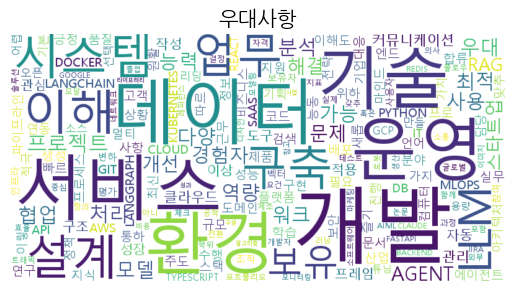

In [511]:
#우대사항 키워드 분석
remove_list = ['경험','또는','관련','기반','AI','활용', '대하']    #불필요한 단어리스트
result_list = []    #불필요한 단어 제거된 결과

for respons_text in df["preferred_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.extend(data_list)   

counter = Counter(result_list)

wc = WordCloud(
    font_path = r"c:\Windows\Fonts\malgun.ttf",
    background_color="white",
    width=800,
    height=400
)

wc.generate_from_frequencies(counter)

plt.Figure(figsize=(5,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("우대사항", fontsize=15)
plt.show()

In [524]:
#네트워크 분석을 위한 데이터 만들기
te = TransactionEncoder()

remove_list = []    #불필요한 단어리스트
result_list = []    #불필요한 단어 제거된 결과

for respons_text in df["preferred_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.append(data_list)   

te_arr = te.fit(result_list).transform(result_list)

df_arr = pd.DataFrame(te_arr, columns=te.columns_)

frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
rules_all = association_rules(frequent_itemsets, metric="support", min_threshold=0)
rules_all = rules_all[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage']]
max_sup  = 0.7   # 예:  이상 같이 나오는 규칙
min_sup  = 0.05   # 예: 12% 이상 같이 나오는 규칙
min_conf = 0.50   # 예: A가 나오면 B도 50% 이상
min_lift = 1.20   # 예: 독립(1.0)보다 의미 있게 높게
min_lev = rules_all['leverage'].quantile(0.50)  # 상위 25%만

# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.1)

# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets,metric="lift",min_threshold=1.2)

rulesV2 = rules_all[
    (rules_all['support'] >= min_sup) &
    (rules_all['support'] <= max_sup) &
    (rules_all['confidence'] >= min_conf) &
    (rules_all['lift'] >= min_lift) &
    (rules_all['leverage'] >= min_lev)
].copy()

rulesV2 = rulesV2.sort_values(
    by=['leverage', 'confidence', 'lift', 'support'],
    ascending=False
)


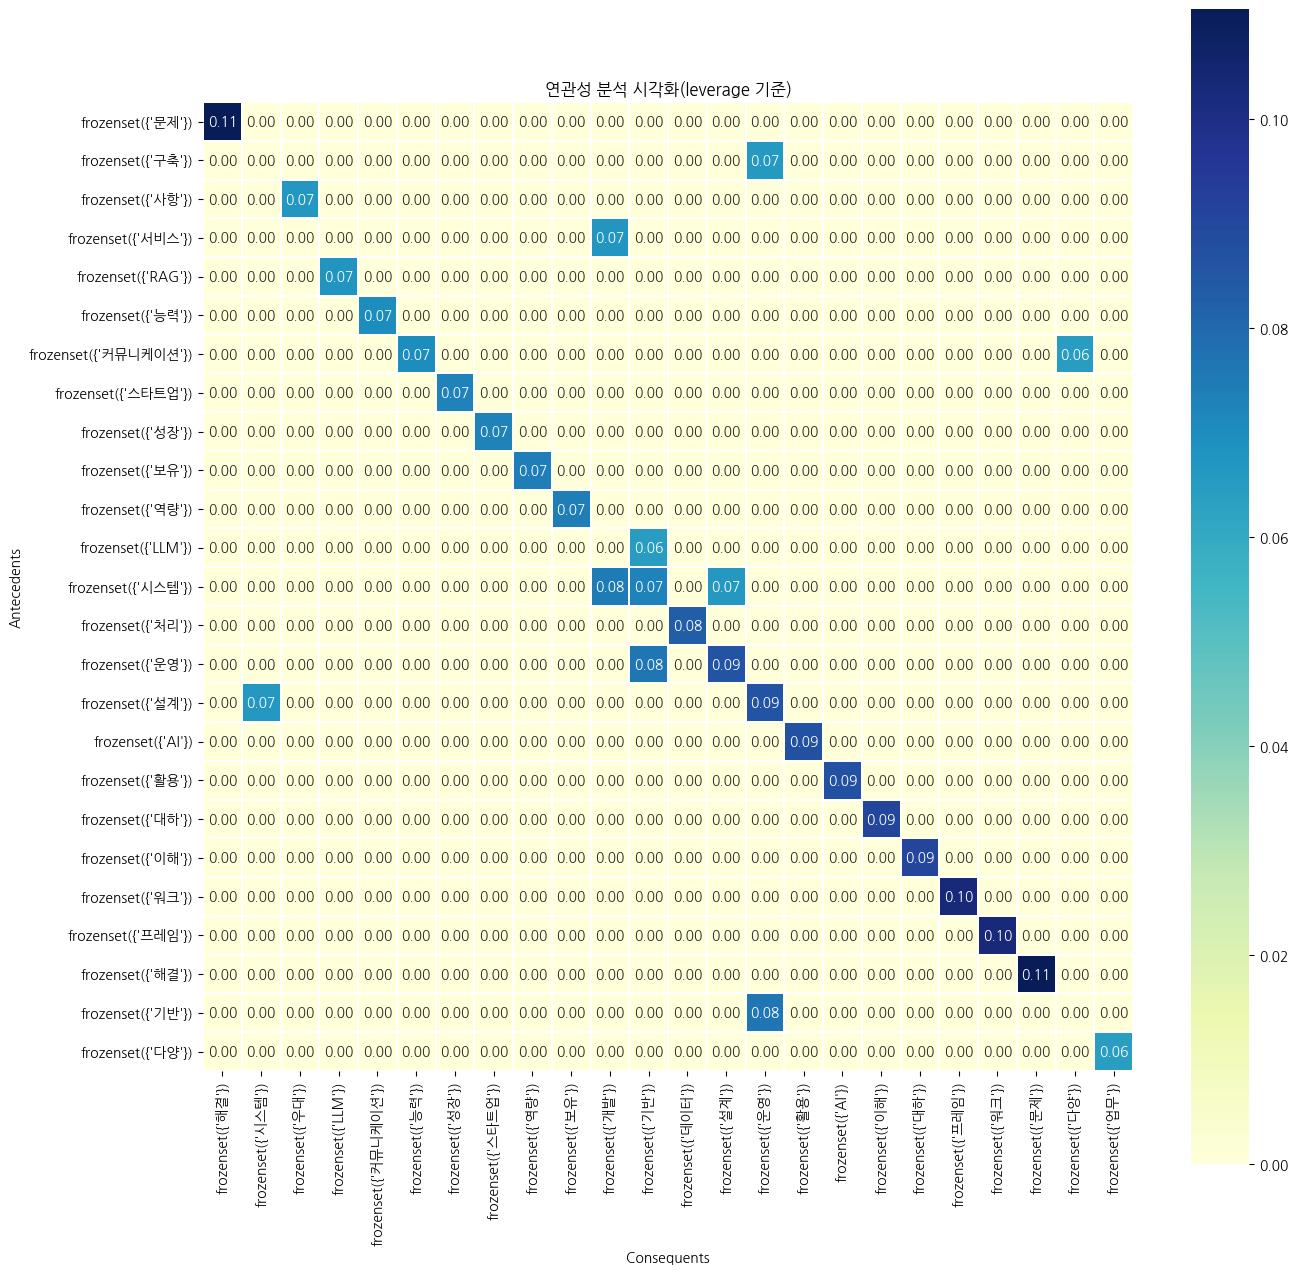

In [526]:
# 히트맵 그리기
pivot_data = rulesV2.head(30).pivot_table(
    index="antecedents",
    columns="consequents",
    values="leverage",
    fill_value=0
)
plt.figure(figsize=(15,15))
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.3, square=True)
plt.title("연관성 분석 시각화(leverage 기준)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.show()

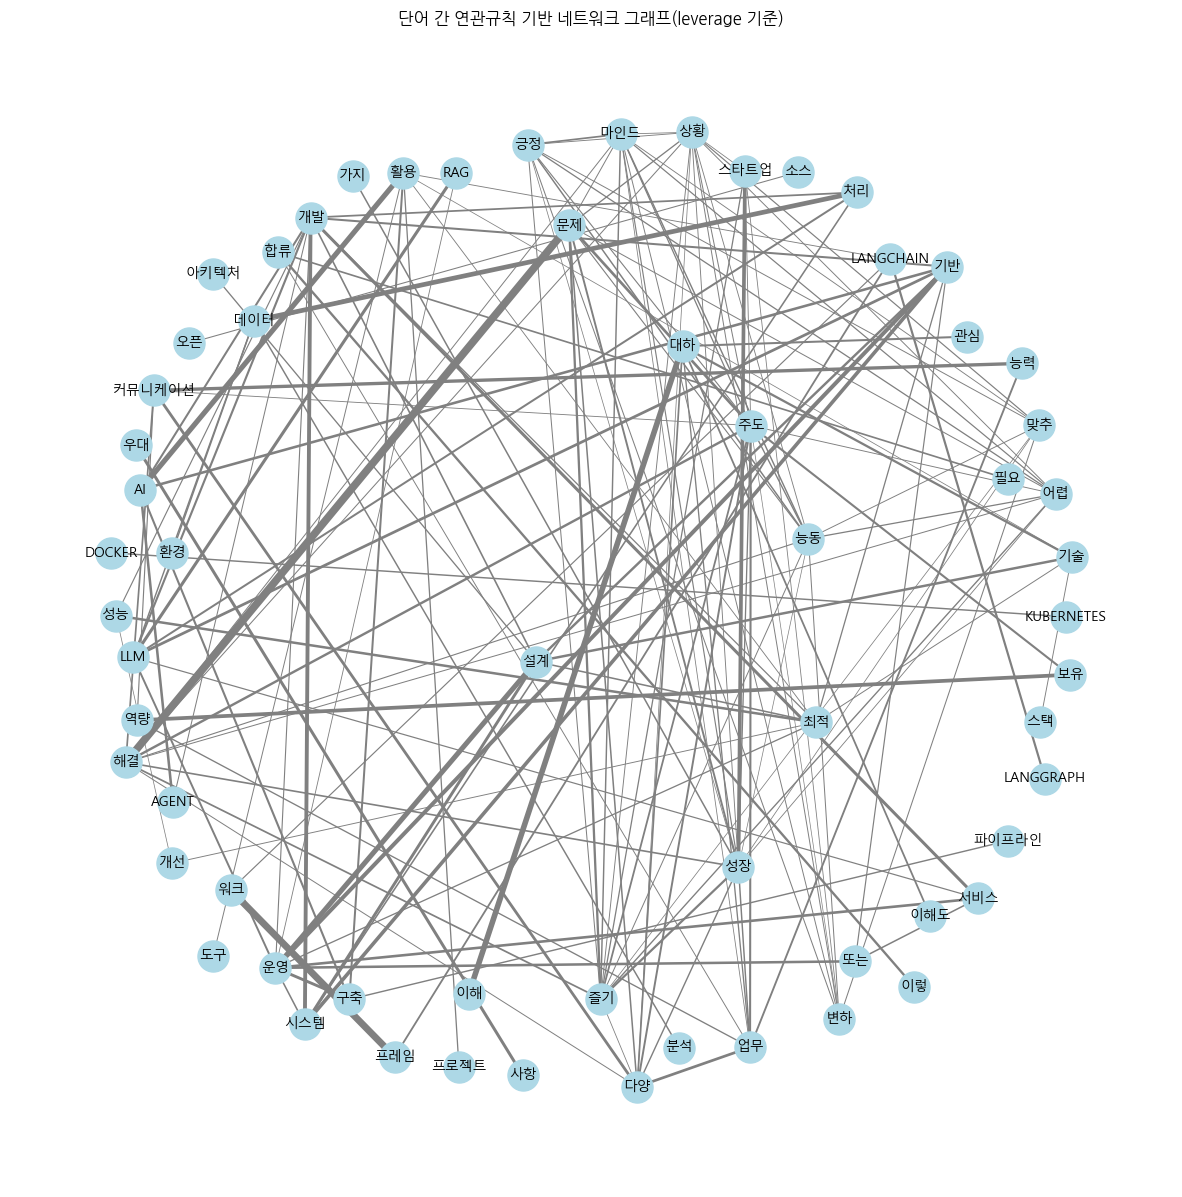

In [527]:
#네트워크 그래프 그리기
# 1. 그래프 생성
G = nx.Graph()

# 2. 엣지 추가
## 보여주고 싶은 데이터 설정하기
my_rules = rulesV2.head(200)

for _ , col_data in my_rules.iterrows():
    # 1) 단어 추출
    antecedent = ",".join(col_data["antecedents"])
    consequent = ",".join(col_data["consequents"])

    # 2) 지표 추출
    weight = col_data["leverage"]

    # 3) 그래프에 정보 추가
    G.add_edge(antecedent, consequent, weight=weight)

# 3. 노드 배치
# position = nx.kamada_kawai_layout(G)
position = nx.spring_layout(G, k=1.0, seed=1)

# 4. 가중치 추출
scale = 1 # 선의 굵기가 너무 굵다면 사이즈를 줄일수 있습니다
edge_weights = [G[u][v]["weight"]*scale for u, v in G.edges()]
w = np.array(edge_weights, dtype=float)
w_norm = (w - w.min()) / (w.max() - w.min() + 1e-9)   # 0~1
w_scaled  = 0.5 + w_norm * 5

# 5. 그리기
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, position, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G, position, edge_color="gray", width=w_scaled)
nx.draw_networkx_labels(G, position, font_size=10, font_family="Malgun Gothic")
plt.title("단어 간 연관규칙 기반 네트워크 그래프(leverage 기준)")
plt.axis("off")
plt.show()

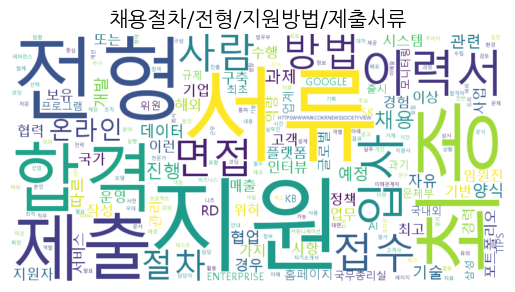

In [528]:
#채용절차/전형/지원방법/제출서류 키워드 분석
remove_list = []    #불필요한 단어리스트
result_list = []    #불필요한 단어 제거된 결과

for respons_text in df["hiring_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.extend(data_list)

counter = Counter(result_list)

wc = WordCloud(
    font_path = r"c:\Windows\Fonts\malgun.ttf",
    background_color="white",
    width=800,
    height=400
)

wc.generate_from_frequencies(counter)

plt.Figure(figsize=(5,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("채용절차/전형/지원방법/제출서류", fontsize=15)
plt.show()

In [529]:
#네트워크 분석을 위한 데이터 만들기
te = TransactionEncoder()

remove_list = ['AI', 'AL','AGENT','에이전트', '기반', '서비스']    #불필요한 단어리스트
result_list = []    #불필요한 단어 제거된 결과

for respons_text in df["hiring_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.append(data_list)   

te_arr = te.fit(result_list).transform(result_list)

df_arr = pd.DataFrame(te_arr, columns=te.columns_)

frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
rules_all = association_rules(frequent_itemsets, metric="support", min_threshold=0)
rules_all = rules_all[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage']]
max_sup  = 0.7   # 예:  이상 같이 나오는 규칙
min_sup  = 0.05   # 예: 12% 이상 같이 나오는 규칙
min_conf = 0.50   # 예: A가 나오면 B도 50% 이상
min_lift = 1.20   # 예: 독립(1.0)보다 의미 있게 높게
min_lev = rules_all['leverage'].quantile(0.50)  # 상위 25%만

# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.1)

# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets,metric="lift",min_threshold=1.2)

rulesV2 = rules_all[
    (rules_all['support'] >= min_sup) &
    (rules_all['support'] <= max_sup) &
    (rules_all['confidence'] >= min_conf) &
    (rules_all['lift'] >= min_lift) &
    (rules_all['leverage'] >= min_lev)
].copy()

rulesV2 = rulesV2.sort_values(
    by=['leverage', 'confidence', 'lift', 'support'],
    ascending=False
)


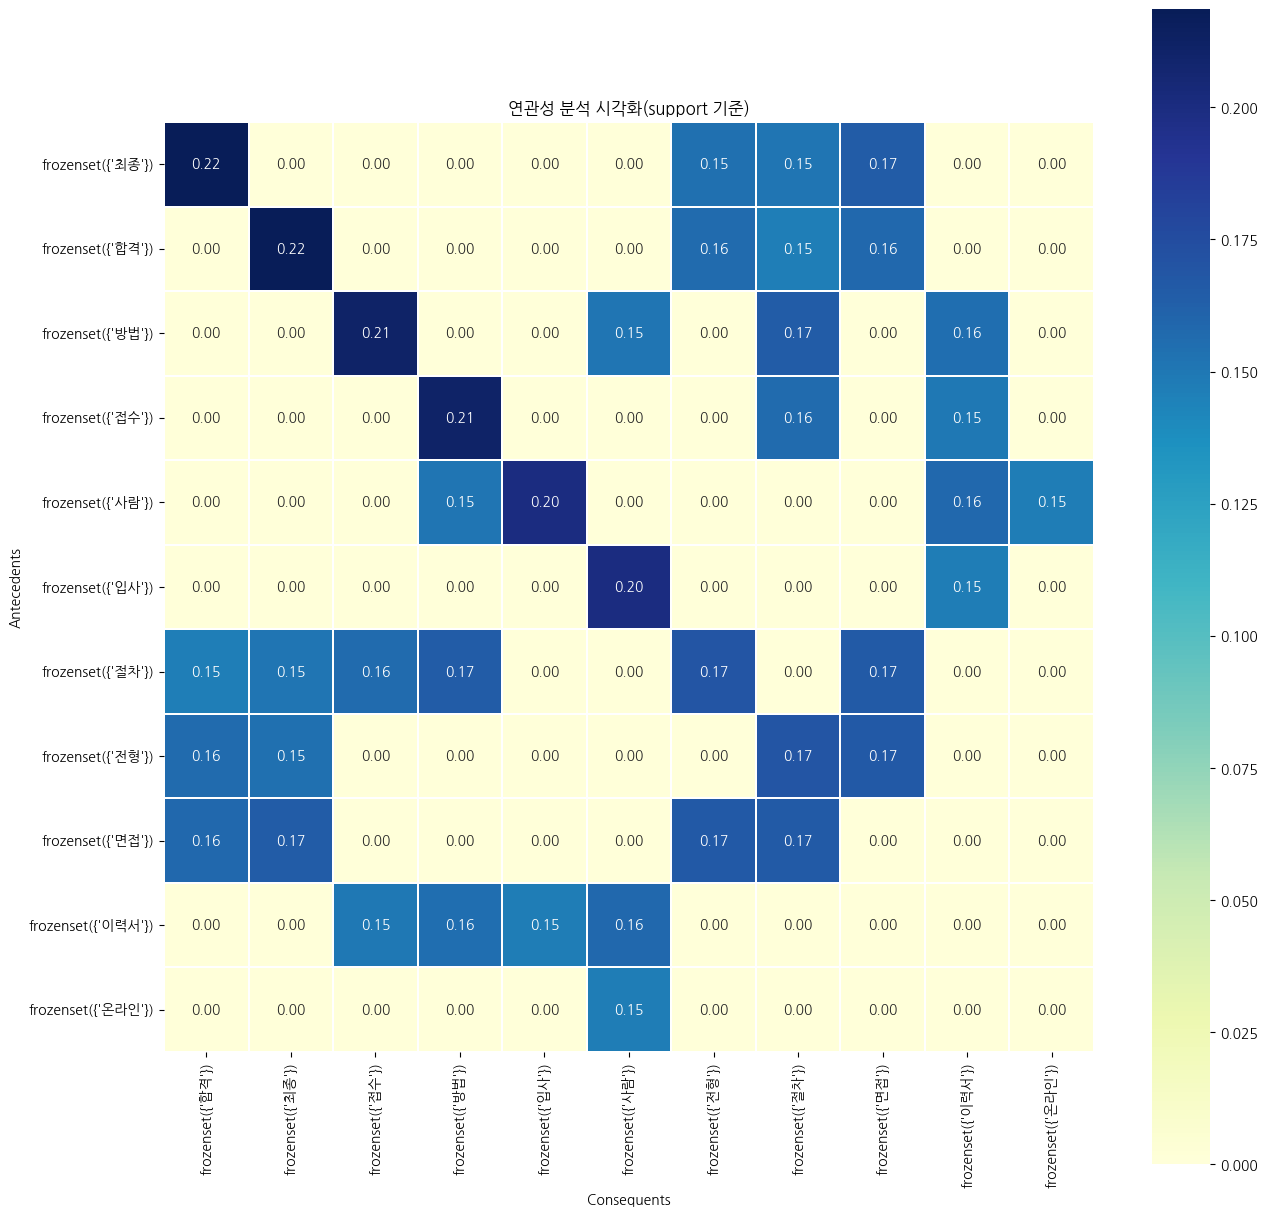

In [531]:
# 히트맵 그리기
pivot_data = rulesV2.head(40).pivot_table(
    index="antecedents",
    columns="consequents",
    values="leverage",
    fill_value=0
)
plt.figure(figsize=(15,15))
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.3, square=True)
plt.title("연관성 분석 시각화(support 기준)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.show()

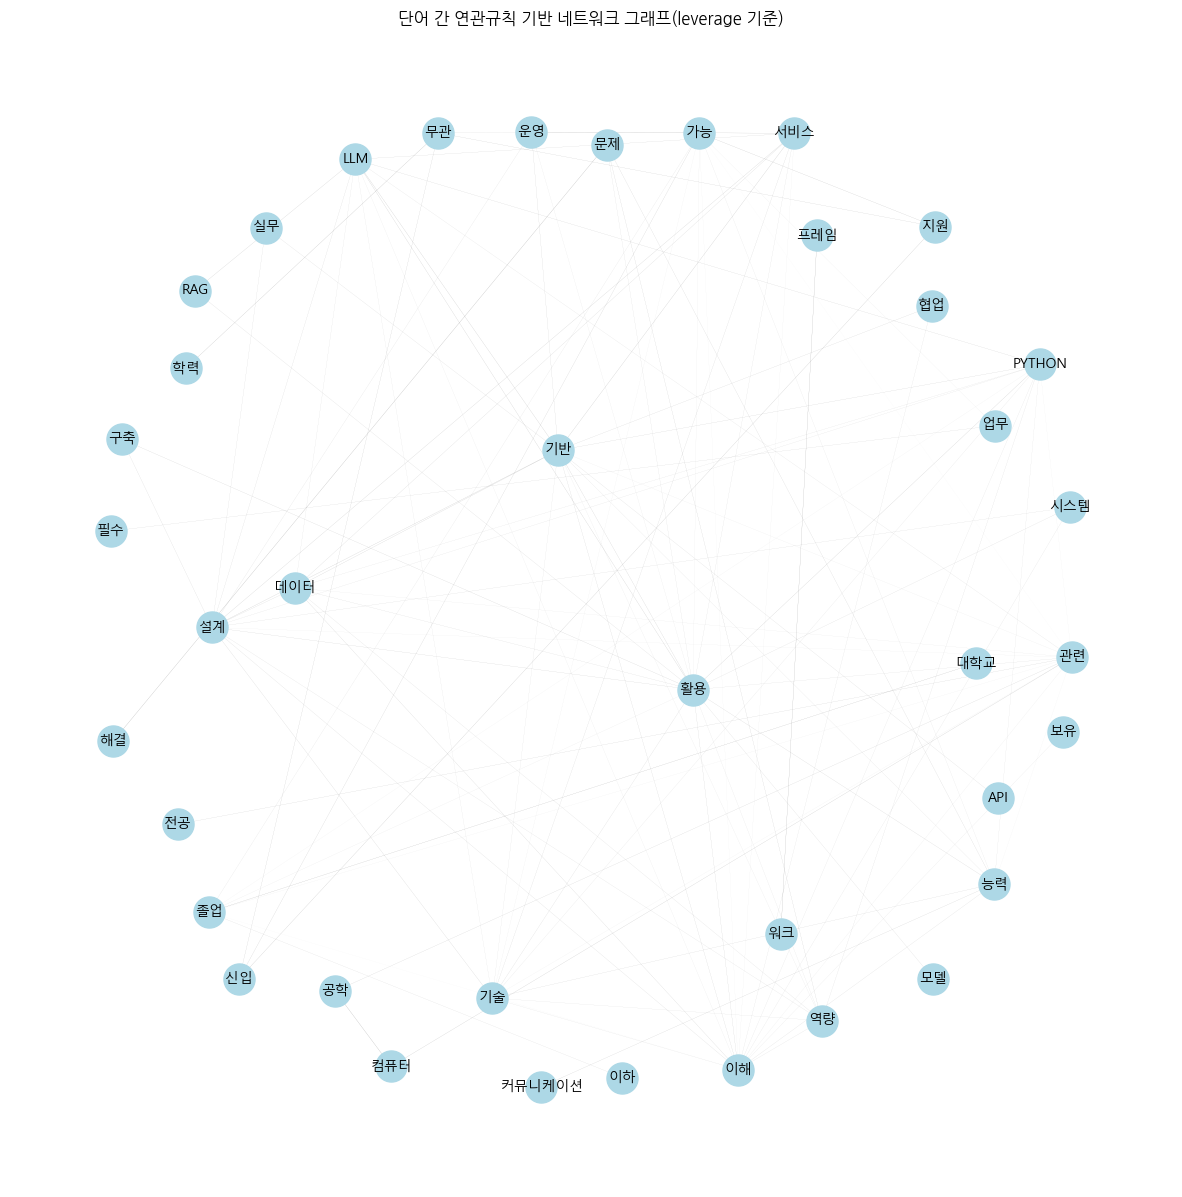

In [532]:
#네트워크 그래프 그리기
# 1. 그래프 생성
G = nx.Graph()

# 2. 엣지 추가
## 보여주고 싶은 데이터 설정하기
my_rules = rules.sort_values(by=["leverage"], ascending=False)

for _ , col_data in my_rules.iterrows():
    # 1) 단어 추출
    antecedent = ",".join(col_data["antecedents"])
    consequent = ",".join(col_data["consequents"])

    # 2) 지표 추출
    weight = col_data["leverage"]

    # 3) 그래프에 정보 추가
    G.add_edge(antecedent, consequent, weight=weight)

# 3. 노드 배치
# position = nx.kamada_kawai_layout(G)
position = nx.spring_layout(G, k=1.0, seed=1)

# 4. 가중치 추출
scale = 1 # 선의 굵기가 너무 굵다면 사이즈를 줄일수 있습니다
edge_weights = [G[u][v]["weight"]*scale for u, v in G.edges()]
w = np.array(edge_weights, dtype=float)
w_norm = (w - w.min()) / (w.max() - w.min() + 1e-9)   # 0~1
w_scaled  = 0.5 + w_norm * 5

# 5. 그리기
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, position, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G, position, edge_color="gray", width=edge_weights)
nx.draw_networkx_labels(G, position, font_size=10, font_family="Malgun Gothic")
plt.title("단어 간 연관규칙 기반 네트워크 그래프(leverage 기준)")
plt.axis("off")
plt.show()

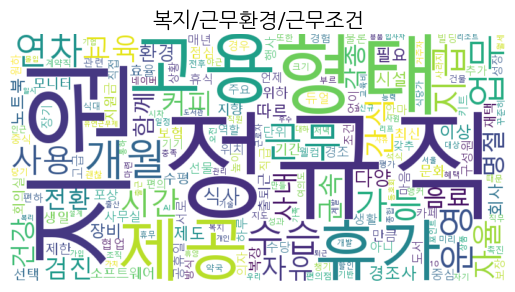

In [533]:
#복지/근무환경/근무조건 키워드 분석
remove_list = []    #불필요한 단어리스트
result_list = []    #불필요한 단어 제거된 결과

for respons_text in df["benefits_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.extend(data_list)

counter = Counter(result_list)

wc = WordCloud(
    font_path = r"c:\Windows\Fonts\malgun.ttf",
    background_color="white",
    width=800,
    height=400
)

wc.generate_from_frequencies(counter)

plt.Figure(figsize=(5,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("복지/근무환경/근무조건", fontsize=15)
plt.show()

In [535]:
#네트워크 분석을 위한 데이터 만들기
te = TransactionEncoder()

remove_list = ['AI', 'AL','AGENT','에이전트', '개발', '기반', '서비스']    #불필요한 단어리스트
result_list = []    #불필요한 단어 제거된 결과

for respons_text in df["benefits_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.append(data_list)   

te_arr = te.fit(result_list).transform(result_list)

df_arr = pd.DataFrame(te_arr, columns=te.columns_)

frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
rules_all = association_rules(frequent_itemsets, metric="support", min_threshold=0)
rules_all = rules_all[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage']]
max_sup  = 0.7   # 예:  이상 같이 나오는 규칙
min_sup  = 0.05   # 예: 12% 이상 같이 나오는 규칙
min_conf = 0.50   # 예: A가 나오면 B도 50% 이상
min_lift = 1.20   # 예: 독립(1.0)보다 의미 있게 높게
min_lev = rules_all['leverage'].quantile(0.50)  # 상위 25%만

# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.1)

# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets,metric="lift",min_threshold=1.2)

rulesV2 = rules_all[
    (rules_all['support'] >= min_sup) &
    (rules_all['support'] <= max_sup) &
    (rules_all['confidence'] >= min_conf) &
    (rules_all['lift'] >= min_lift) &
    (rules_all['leverage'] >= min_lev)
].copy()

rulesV2 = rulesV2.sort_values(
    by=['leverage', 'confidence', 'lift', 'support'],
    ascending=False
)


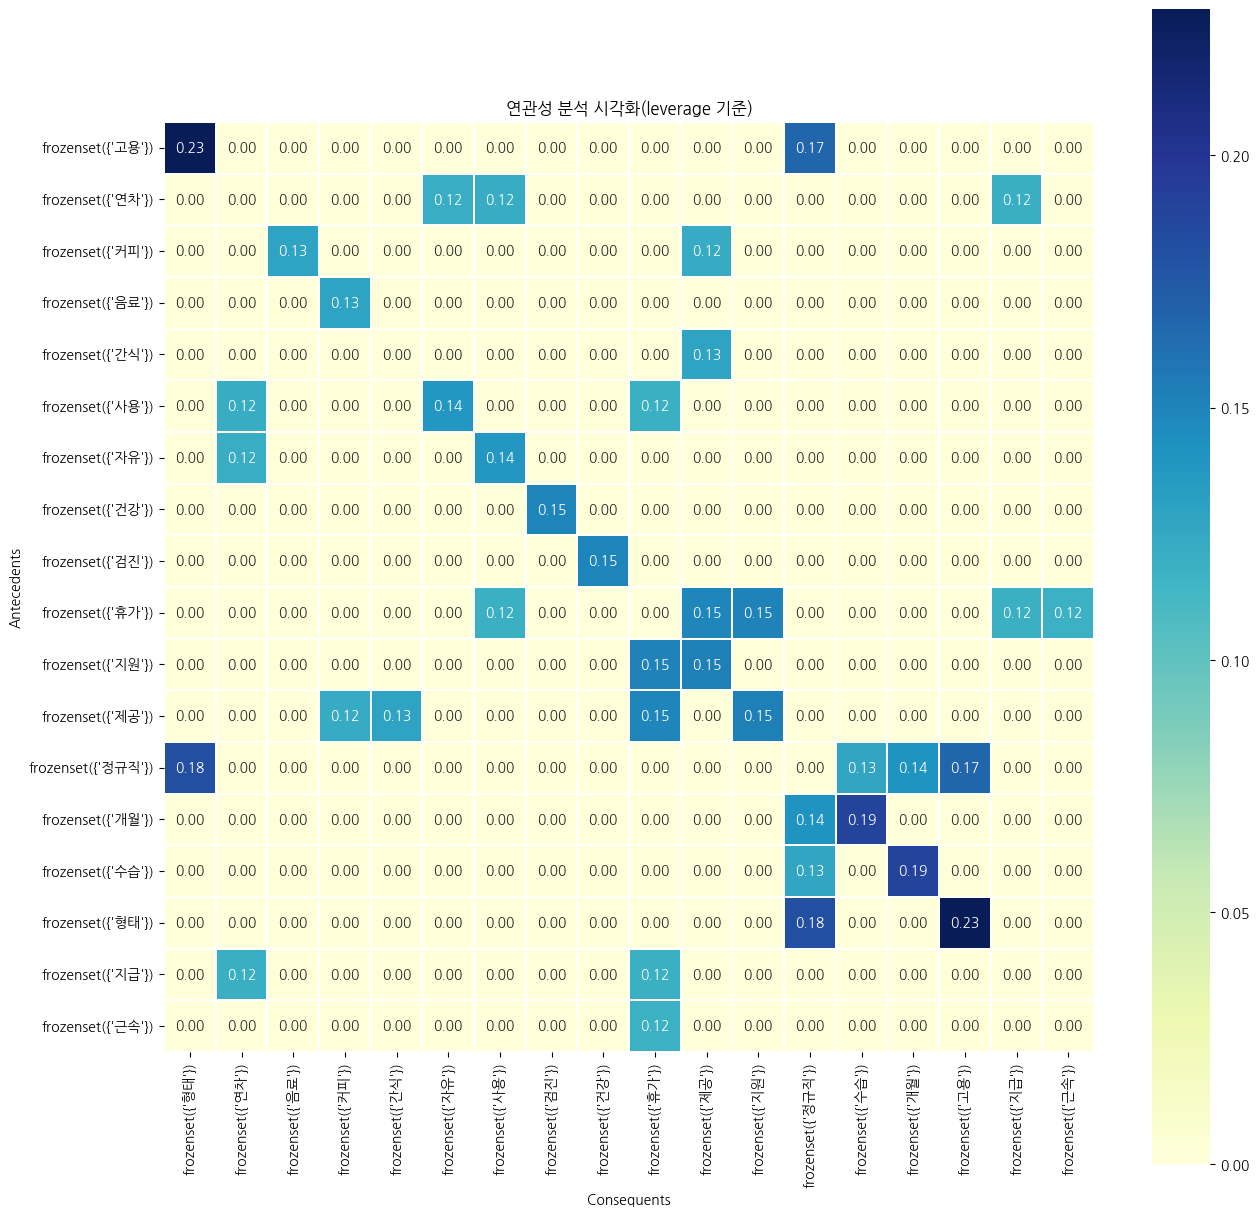

In [538]:
# 히트맵 그리기
pivot_data = rulesV2.head(40).pivot_table(
    index="antecedents",
    columns="consequents",
    values="leverage",
    fill_value=0
)
plt.figure(figsize=(15,15))
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.3, square=True)
plt.title("연관성 분석 시각화(leverage 기준)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.show()

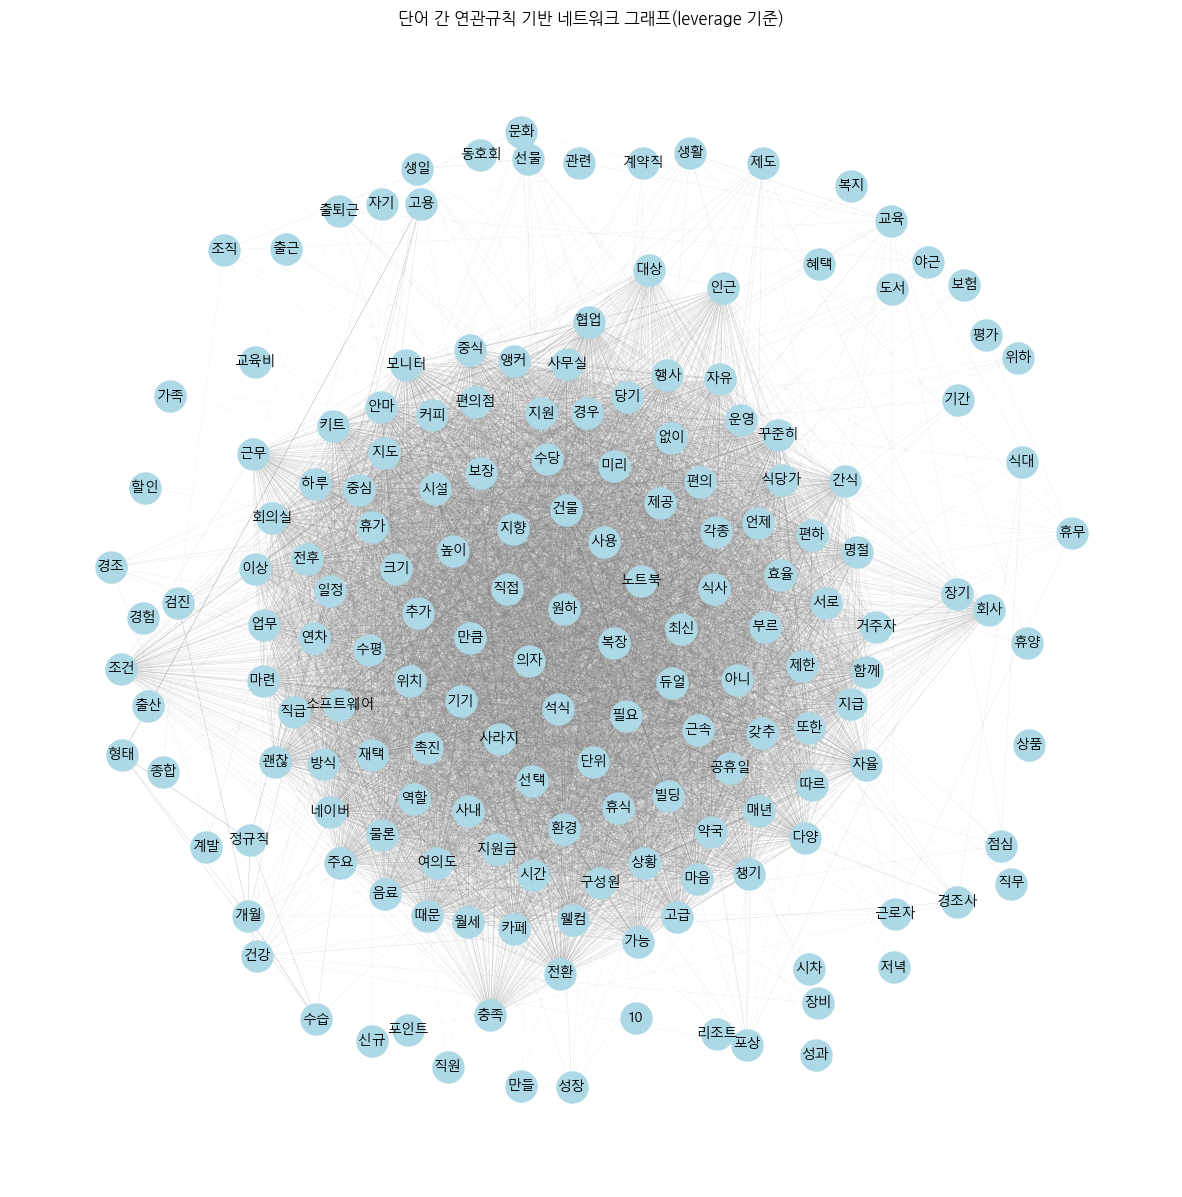

In [539]:
#네트워크 그래프 그리기
# 1. 그래프 생성
G = nx.Graph()

# 2. 엣지 추가
## 보여주고 싶은 데이터 설정하기
my_rules = rulesV2

for _ , col_data in my_rules.iterrows():
    # 1) 단어 추출
    antecedent = ",".join(col_data["antecedents"])
    consequent = ",".join(col_data["consequents"])

    # 2) 지표 추출
    weight = col_data["leverage"]

    # 3) 그래프에 정보 추가
    G.add_edge(antecedent, consequent, weight=weight)

# 3. 노드 배치
# position = nx.kamada_kawai_layout(G)
position = nx.spring_layout(G, k=1.0, seed=1)

# 4. 가중치 추출
scale = 1 # 선의 굵기가 너무 굵다면 사이즈를 줄일수 있습니다
edge_weights = [G[u][v]["weight"]*scale for u, v in G.edges()]
w = np.array(edge_weights, dtype=float)
w_norm = (w - w.min()) / (w.max() - w.min() + 1e-9)   # 0~1
w_scaled  = 0.5 + w_norm * 5

# 5. 그리기
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, position, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G, position, edge_color="gray", width=edge_weights)
nx.draw_networkx_labels(G, position, font_size=10, font_family="Malgun Gothic")
plt.title("단어 간 연관규칙 기반 네트워크 그래프(leverage 기준)")
plt.axis("off")
plt.show()

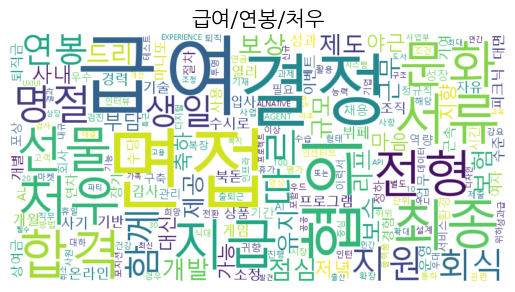

In [157]:
#급여/연봉/처우 키워드 분석
remove_list = []    #불필요한 단어리스트
result_list = []    #불필요한 단어 제거된 결과

for respons_text in df["salary_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.extend(data_list)

counter = Counter(result_list)

wc = WordCloud(
    font_path = r"c:\Windows\Fonts\malgun.ttf",
    background_color="white",
    width=800,
    height=400
)

wc.generate_from_frequencies(counter)

plt.Figure(figsize=(5,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("급여/연봉/처우", fontsize=15)
plt.show()

In [542]:
#네트워크 분석을 위한 데이터 만들기
te = TransactionEncoder()

remove_list = []    #불필요한 단어리스트
result_list = []    #불필요한 단어 제거된 결과

for respons_text in df["salary_text"]:
    if pd.isna(respons_text):
        continue
    respons_list = ast.literal_eval(respons_text)

    data_list = []
    for respons_text in respons_list:
        respons_text = respons_text.upper() #대문자화
        if respons_text in remove_list:
            continue
        data_list.append(respons_text)
    data_list = list(set(data_list)) # 중복제거
    result_list.append(data_list)   

te_arr = te.fit(result_list).transform(result_list)

df_arr = pd.DataFrame(te_arr, columns=te.columns_)

frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
rules_all = association_rules(frequent_itemsets, metric="support", min_threshold=0)
rules_all = rules_all[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage']]
max_sup  = 0.7   # 예:  이상 같이 나오는 규칙
min_sup  = 0.05   # 예: 12% 이상 같이 나오는 규칙
min_conf = 0.50   # 예: A가 나오면 B도 50% 이상
min_lift = 1.20   # 예: 독립(1.0)보다 의미 있게 높게
min_lev = rules_all['leverage'].quantile(0.50)  # 상위 25%만

# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.1)

# frequent_itemsets = apriori(df_arr, min_support=0.01, use_colnames=True, max_len=2)
# rules = association_rules(frequent_itemsets,metric="lift",min_threshold=1.2)

rulesV2 = rules_all[
    (rules_all['support'] >= min_sup) &
    (rules_all['support'] <= max_sup) &
    (rules_all['confidence'] >= min_conf) &
    (rules_all['lift'] >= min_lift) &
    (rules_all['leverage'] >= min_lev)
].copy()

rulesV2 = rulesV2.sort_values(
    by=['leverage', 'confidence', 'lift', 'support'],
    ascending=False
)


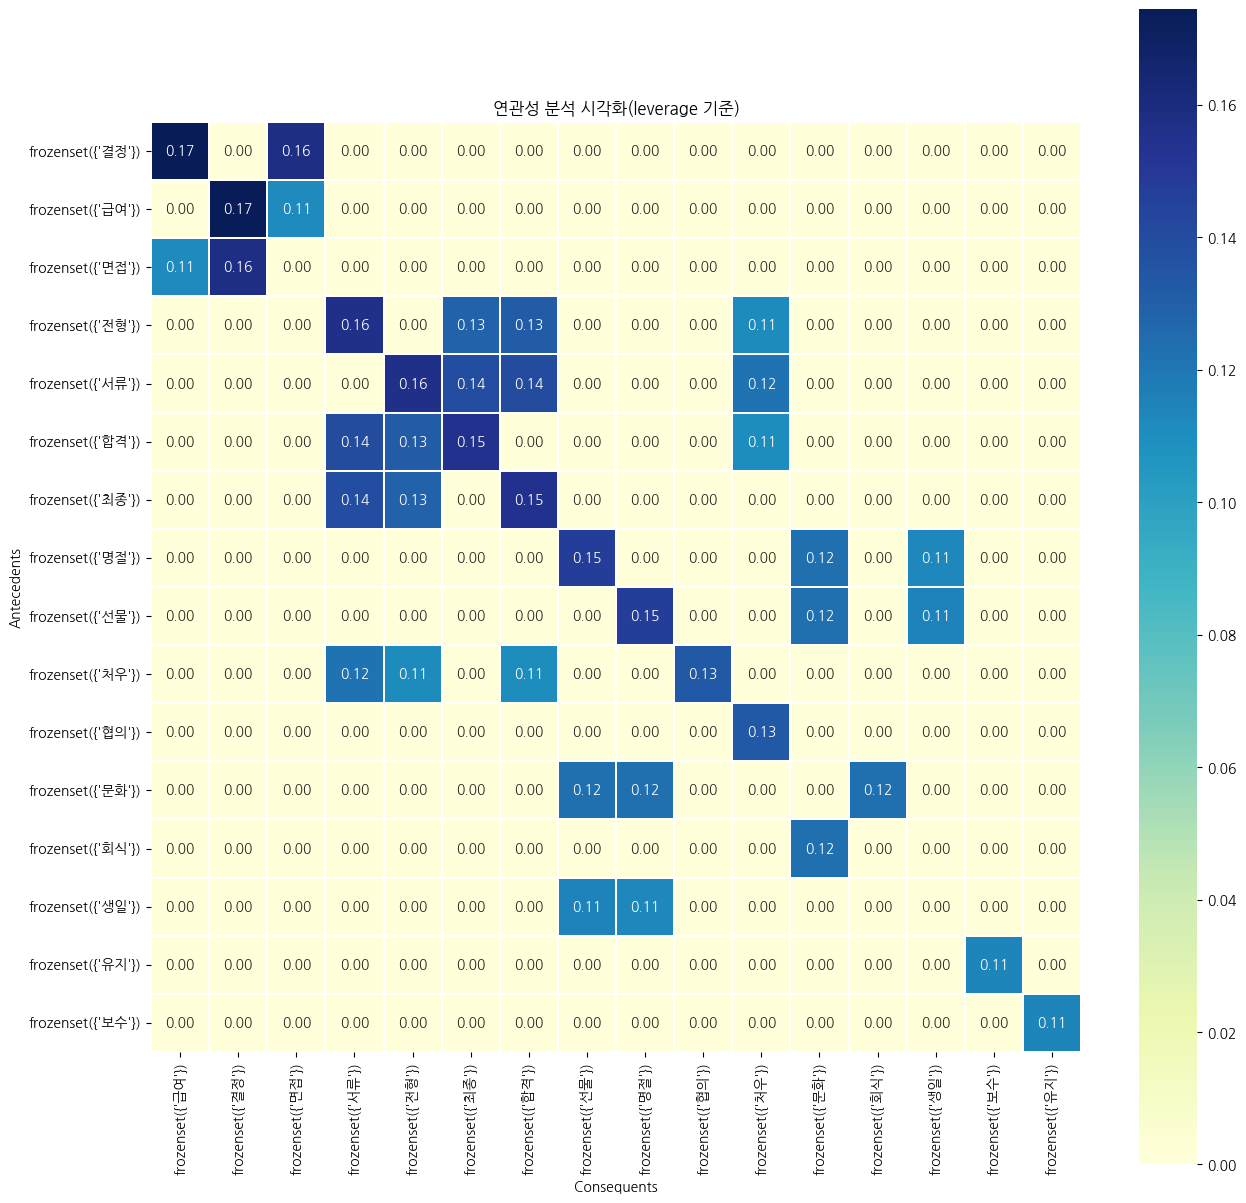

In [543]:
# 히트맵 그리기
pivot_data = rulesV2.head(40).pivot_table(
    index="antecedents",
    columns="consequents",
    values="leverage",
    fill_value=0
)
plt.figure(figsize=(15,15))
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.3, square=True)
plt.title("연관성 분석 시각화(leverage 기준)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.show()
    

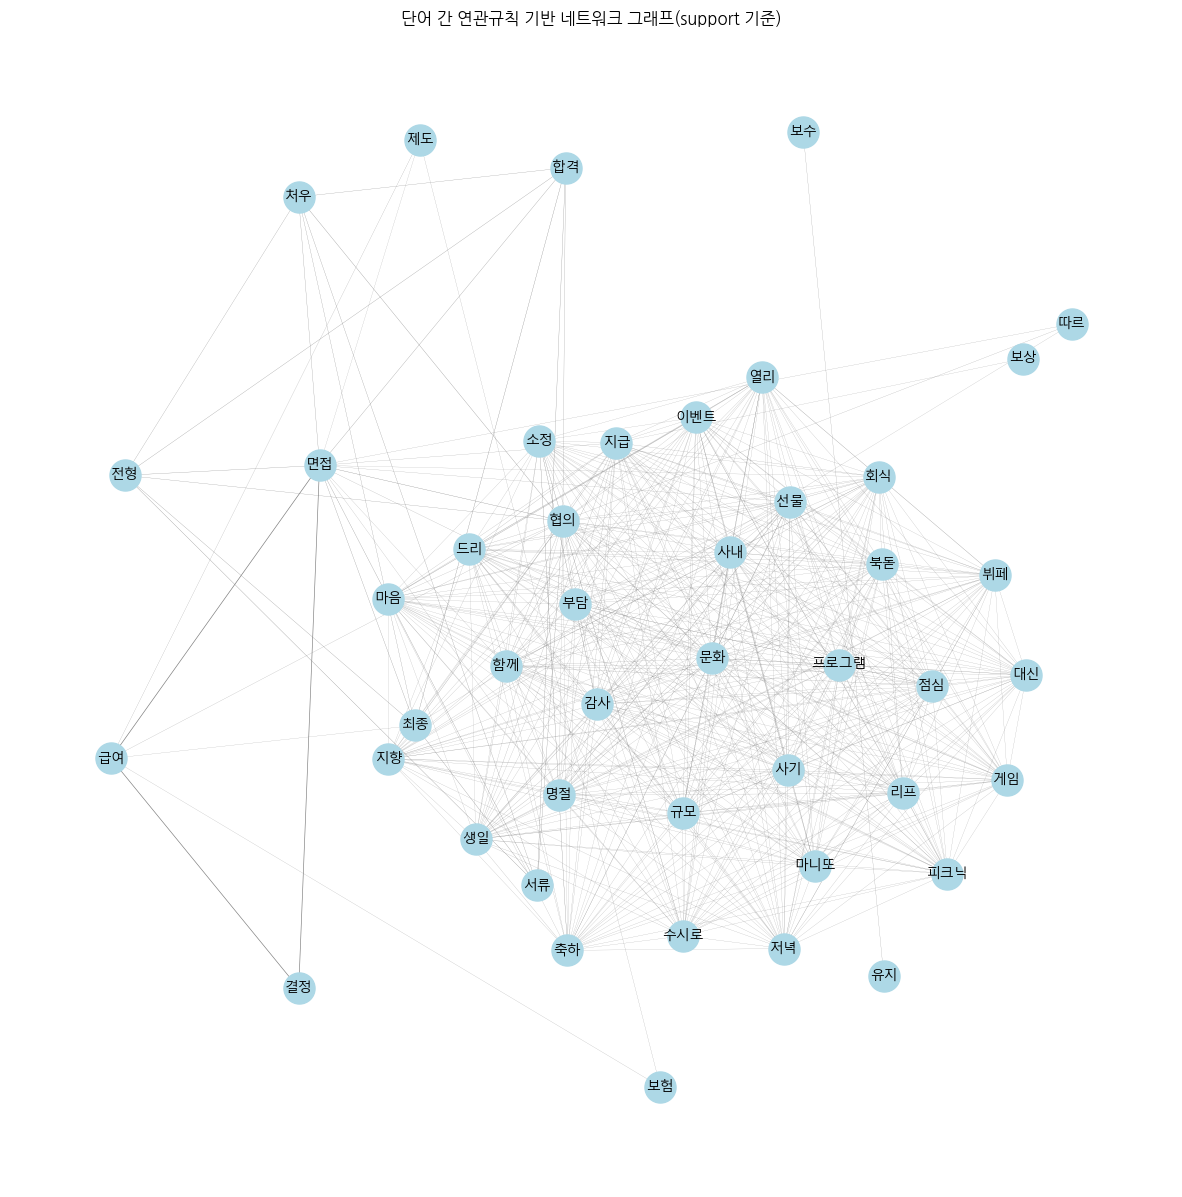

In [160]:
#네트워크 그래프 그리기
# 1. 그래프 생성
G = nx.Graph()

# 2. 엣지 추가
## 보여주고 싶은 데이터 설정하기
my_rules = rules.sort_values(by=["support"], ascending=False)

for _ , col_data in my_rules.iterrows():
    # 1) 단어 추출
    antecedent = ",".join(col_data["antecedents"])
    consequent = ",".join(col_data["consequents"])

    # 2) 지표 추출
    weight = col_data["support"]

    # 3) 그래프에 정보 추가
    G.add_edge(antecedent, consequent, weight=weight)

# 3. 노드 배치
# position = nx.kamada_kawai_layout(G)
position = nx.spring_layout(G, k=1.0, seed=1)

# 4. 가중치 추출
scale = 1 # 선의 굵기가 너무 굵다면 사이즈를 줄일수 있습니다
edge_weights = [G[u][v]["weight"]*scale for u, v in G.edges()]
w = np.array(edge_weights, dtype=float)
w_norm = (w - w.min()) / (w.max() - w.min() + 1e-9)   # 0~1
w_scaled  = 0.5 + w_norm * 5

# 5. 그리기
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, position, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G, position, edge_color="gray", width=edge_weights)
nx.draw_networkx_labels(G, position, font_size=10, font_family="Malgun Gothic")
plt.title("단어 간 연관규칙 기반 네트워크 그래프(support 기준)")
plt.axis("off")
plt.show()